# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


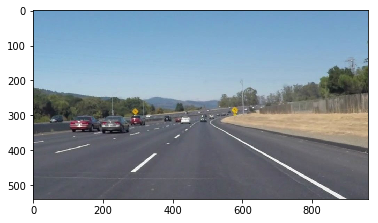

In [328]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [341]:
import math
import operator

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    """
    To extrapolate the lines, we will separate the left lines and right lines based on slope
    - If slope > 0 it is part of the right line and if slope < 0 it is part of left line..
    - We will put the center points in left and right arrays
    - After getting left and right arrays, we will get the average slope for the left line 
    and average slope for the right line..
    - From the center points and slope values we should be able to calculate two extreme points
    """
    leftLineMidPoints=[]
    rightLineMidPoints=[]
    rightLineSlopes=[]
    leftLineSlopes=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # ignore infinite slopes
            if(x2-x1 != 0):
                m = (y2-y1)/(x2-x1);
                centerPoint = ((x1+x2)/2,((y2+y1)/2));
                if m > 0:
                    # Lines with positive slopes go to the right side
                    rightLineMidPoints.append(centerPoint);
                    rightLineSlopes.append(m);
                else:      
                    leftLineMidPoints.append(centerPoint);
                    leftLineSlopes.append(m);
                
        
    leftAverageSlope = sum(leftLineSlopes)/len(leftLineSlopes);
    rightAverageSlope = sum(rightLineSlopes)/len(rightLineSlopes);
    
    # needs to be done tuple wise so using numpy; axis =0 implies sum row wise
    leftCenterPoint=np.divide(np.sum(leftLineMidPoints,axis=0),len(leftLineMidPoints));
    print(leftCenterPoint);
    rightCenterPoint = np.divide(np.sum(rightLineMidPoints,axis=0),len(rightLineMidPoints));
    print(rightCenterPoint);
    
    imshape = img.shape;
    #For left line one point will always pass thru point (x,imshape[0] )
    # having y coordinate with x coordinate unknow and mid point of this line is also known
    # y1+y3/2 = y2 x1+x3/2 = x2 (Point (o,imshape[0] and mid point (leftCenterPoint)))
    leftLineLowerX = int(leftCenterPoint[0]-((leftCenterPoint[1]-imshape[0])/leftAverageSlope));
    print("Left")
    leftLineUpperX = int(leftCenterPoint[0]+((320-leftCenterPoint[1])/leftAverageSlope));
    print(leftLineLowerX,leftLineUpperX);
    #For right Line we have centerPoint and extreme point (imshape[0],imshape[1])
   
    rightLineLowerX = int(rightCenterPoint[0]-((rightCenterPoint[1]-imshape[0])/rightAverageSlope))
    rightLineUpperX = int(rightCenterPoint[0]+((320-rightCenterPoint[1])/rightAverageSlope));
    print(rightLineLowerX,rightLineUpperX);
    cv2.line(img, (leftLineLowerX,imshape[0]), (leftLineUpperX,320), color, thickness)
    cv2.line(img, (rightLineLowerX,imshape[0]), (rightLineUpperX, 320), color, thickness)
    #plt.imshow(img);

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [342]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

[ 389.5         379.21428571]
[ 721.625  444.25 ]
Left
169 470
891 501


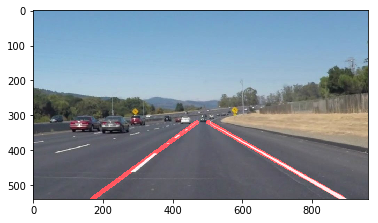

In [343]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Converting the image to grayscale
grayImage = grayscale(image);

# Applying Gaussian smoothing
kernelSize = 5;
gaussianImage = gaussian_blur(grayImage, kernelSize);

# Applying CannyEdge to get the points of interest
lowThreshold = 50;
highThreshold = 150;
edgeImage = canny(gaussianImage, lowThreshold, highThreshold);

# Region of interest selection
imshape = image.shape;
vertices = np.array([[(0,imshape[0]),(460, 315), (480, 315), (imshape[1],imshape[0])]], dtype=np.int32)
maskedImage = region_of_interest(edgeImage, vertices);

# Hough Transform on Edge detected image, returns array of lines
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
minLineLength = 5 #minimum number of pixels making up a line
maxLineGap = 15    # maximum gap in pixels between connectable line segments

houghLineImage = hough_lines(maskedImage, rho, theta, threshold, minLineLength
                   , maxLineGap);
#plt.imshow(houghLineImage);

lineWeightImage = weighted_img(image, houghLineImage);
plt.imshow(lineWeightImage);





## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [349]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
count =0;

In [350]:
def process_image(image):
    global count
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.

    # Converting the image to grayscale
    grayImage = grayscale(image);

    # Applying Gaussian smoothing
    kernelSize = 5;
    gaussianImage = gaussian_blur(grayImage, kernelSize);

    # Applying CannyEdge to get the points of interest
    lowThreshold = 50;
    highThreshold = 150;
    edgeImage = canny(gaussianImage, lowThreshold, highThreshold);

    # Region of interest selection
    imshape = image.shape;
    vertices = np.array([[(0,imshape[0]),(460, 315), (480, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedImage = region_of_interest(edgeImage, vertices);

    # Hough Transform on Edge detected image, returns array of lines
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    minLineLength = 5 #minimum number of pixels making up a line
    maxLineGap = 15    # maximum gap in pixels between connectable line segments

    houghLineImage = hough_lines(maskedImage, rho, theta, threshold, minLineLength
                       , maxLineGap);
    #plt.imshow(houghLineImage);

    lineWeightImage = weighted_img(image, houghLineImage);
    #plt.imshow(lineWeightImage);
    cv2.imwrite("test_images/frame{:d}.jpg".format(count),lineWeightImage);
    count+=1
    return lineWeightImage

Let's try the one with the solid white lane on the right first ...

In [353]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[ 340.10714286  404.67857143]
[ 665.375  419.5  ]
Left
152 457
856 507
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|          | 2/222 [00:00<00:12, 18.10it/s]

[ 340.10714286  404.67857143]
[ 665.375  419.5  ]
Left
152 457
856 507
[ 337.54166667  408.5       ]
[ 700.54545455  442.22727273]
Left
156 459
859 501
[ 319.38461538  421.46153846]
[ 742.38461538  468.88461538]
Left
155 459
861 493
[ 315.88235294  422.64705882]
[ 706.65384615  446.65384615]
Left
153 458
861 496


  3%|▎         | 6/222 [00:00<00:11, 18.11it/s]

[ 380.          376.16666667]
[ 726.78571429  459.        ]
Left
144 460
860 497
[ 407.81818182  355.36363636]
[ 723.91666667  455.58333333]
Left
165 454
863 499
[ 354.63636364  393.45454545]
[ 687.39473684  432.5       ]
Left
63 500
856 510
[ 351.22222222  396.44444444]
[ 698.      436.4375]
Left
96 486
866 508


  5%|▍         | 10/222 [00:00<00:11, 17.90it/s]

[ 365.          386.43333333]
[ 596.21428571  434.71428571]
Left
139 462
794 379
[ 382.25        375.10714286]
[ 652.79166667  414.33333333]
Left
145 461
860 496
[ 360.26315789  393.78947368]
[ 709.95833333  452.25      ]
Left
157 462
851 496
[ 371.13636364  385.31818182]
[ 626.22222222  402.66666667]
Left
162 459
871 478


  6%|▋         | 14/222 [00:00<00:11, 18.29it/s]

[ 314.625    425.34375]
[ 689.65625  441.375  ]
Left
155 460
850 492
[ 319.96428571  419.03571429]
[ 708.19230769  453.23076923]
Left
149 459
849 491
[ 321.84615385  417.96153846]
[ 660.35714286  421.28571429]
Left
160 451
847 500
[ 335.78125  407.34375]
[ 669.55  425.6 ]
Left
133 468
843 508


  8%|▊         | 18/222 [00:01<00:12, 16.75it/s]

[ 314.33333333  418.4       ]
[ 670.29411765  423.94117647]
Left
137 457
855 504
[ 400.33333333  359.11111111]
[ 706.80769231  468.38461538]
Left
156 453
821 468
[ 398.95454545  361.90909091]
[ 681.1875  435.    ]
Left
143 459
846 500
[ 378.11538462  378.30769231]
[ 647.22222222  412.27777778]
Left
144 462
849 501


  9%|▉         | 20/222 [00:01<00:11, 17.14it/s]

[ 337.09375  407.875  ]
[ 707.6  453.2]
Left
122 479
844 498


 10%|▉         | 22/222 [00:01<00:24,  8.01it/s]

[ 393.36666667  367.9       ]
[ 674.92857143  432.64285714]
Left
142 463
842 499
[ 386.5      373.78125]
[ 715.4375  457.625 ]
Left
162 458
845 498
[ 366.15  386.95]
[ 673.22222222  431.72222222]
Left
145 462
837 503


 11%|█         | 24/222 [00:02<00:30,  6.51it/s]

[ 322.25        416.14285714]
[ 714.78571429  455.78571429]
Left
147 457
848 498


 12%|█▏        | 26/222 [00:02<00:31,  6.20it/s]

[ 353.8         395.23333333]
[ 703.38888889  449.33333333]
Left
150 459
845 500
[ 322.96153846  418.26923077]
[ 703.25  450.05]
Left
158 455
846 496


 13%|█▎        | 28/222 [00:02<00:27,  7.08it/s]

[ 305.33333333  431.03333333]
[ 676.875  432.75 ]
Left
152 461
845 499
[ 350.79166667  398.        ]
[ 671.375   430.0625]
Left
151 460
843 499


 13%|█▎        | 29/222 [00:02<00:29,  6.57it/s]

[ 412.16666667  353.45833333]
[ 675.27777778  431.72222222]
Left
155 458
846 498


 14%|█▎        | 30/222 [00:03<00:33,  5.80it/s]

[ 403.          359.77777778]
[ 714.57142857  453.85714286]
Left
144 459
849 504


 14%|█▍        | 32/222 [00:03<00:34,  5.48it/s]

[ 362.28571429  387.64285714]
[ 715.1  455.5]
Left
130 465
849 499
[ 336.40909091  405.63636364]
[ 683.625  434.5  ]
Left
122 472
849 504


 15%|█▍        | 33/222 [00:03<00:42,  4.41it/s]

[ 379.92307692  375.80769231]
[ 716.42857143  454.5       ]
Left
149 458
849 506


 15%|█▌        | 34/222 [00:04<00:44,  4.19it/s]

[ 370.92307692  383.11538462]
[ 685.375  437.   ]
Left
154 458
845 503
[ 341.64705882  405.14705882]
[ 639.83333333  407.29166667]
Left
157 458
850 501


 17%|█▋        | 37/222 [00:04<00:34,  5.39it/s]

[ 341.07142857  405.32142857]
[ 652.80769231  416.88461538]
Left
152 460
858 491
[ 322.58333333  419.875     ]
[ 657.03571429  418.28571429]
Left
161 456
858 494


 18%|█▊        | 40/222 [00:05<00:33,  5.49it/s]

[ 335.3  408.8]
[ 661.57692308  422.84615385]
Left
151 459
848 497
[ 338.375       406.08333333]
[ 691.14285714  442.71428571]
Left
155 455
843 498
[ 345.25        399.66666667]
[ 650.          414.61111111]
Left
150 455
836 509


 20%|█▉        | 44/222 [00:05<00:22,  8.00it/s]

[ 402.65  358.85]
[ 707.22727273  453.22727273]
Left
159 454
846 493
[ 374.68181818  378.81818182]
[ 663.55882353  423.05882353]
Left
112 470
837 510
[ 349.67857143  395.25      ]
[ 736.          469.84615385]
Left
144 456
845 502


 21%|██        | 46/222 [00:05<00:18,  9.61it/s]

[ 337.19230769  405.42307692]
[ 726.85714286  462.85714286]
Left
136 464
843 510
[ 389.68181818  367.5       ]
[ 687.09090909  437.09090909]
Left
147 456
844 508
[ 379.          374.53333333]
[ 719.15384615  454.96153846]
Left
143 456
845 518


 22%|██▏       | 48/222 [00:05<00:19,  9.06it/s]

[ 377.41666667  375.29166667]
[ 731.70833333  465.04166667]
Left
140 457
842 517
[ 346.9   399.35]
[ 668.06666667  426.3       ]
Left
151 457
842 504


 23%|██▎       | 52/222 [00:05<00:15, 10.74it/s]

[ 342.45454545  400.27272727]
[ 698.6         446.33333333]
Left
150 452
849 495
[ 333.          407.33333333]
[ 673.58333333  428.5       ]
Left
143 458
846 504
[ 347.61538462  395.57692308]
[ 641.03846154  419.11538462]
Left
127 462
844 474


 24%|██▍       | 54/222 [00:06<00:14, 11.94it/s]

[ 316.75        417.08333333]
[ 727.66666667  463.88888889]
Left
145 451
845 504
[ 391.35714286  364.14285714]
[ 669.1  425.7]
Left
127 457
846 505
[ 375.          375.57692308]
[ 712.5         454.94444444]
Left
131 457
852 491
[ 383.    371.75]
[ 693.40909091  443.09090909]
Left
135 459


 26%|██▌       | 58/222 [00:06<00:12, 13.23it/s]

837 510
[ 357.14285714  389.82142857]
[ 687.55555556  441.66666667]
Left
121 466
841 496
[ 380.33333333  374.45833333]
[ 681.88888889  439.88888889]
Left
133 461
837 495
[ 357.5         389.23076923]
[ 684.78571429  441.46428571]
Left
134 459
831 504
[ 345.91666667  397.79166667]
[ 638.57142857  409.53571429]
Left
142 457
847 495


 29%|██▉       | 64/222 [00:06<00:09, 16.11it/s]

[ 363.36666667  385.73333333]
[ 679.26666667  436.36666667]
Left
135 460
845 492
[ 303.41666667  425.79166667]
[ 636.21428571  407.78571429]
Left
140 454
834 504
[ 296.13333333  430.8       ]
[ 651.86363636  418.22727273]
Left
132 462
840 499
[ 308.57142857  422.89285714]
[ 664.875   428.4375]
Left
134 461
831 503


 30%|██▉       | 66/222 [00:06<00:09, 17.07it/s]

[ 340.20833333  400.375     ]
[ 688.36363636  441.09090909]
Left
136 457
835 508
[ 423.77777778  343.72222222]
[ 639.44444444  410.66666667]
Left
75 465
837 500
[ 355.70833333  387.375     ]
[ 662.9   425.15]
Left
122 458
832 507
[ 357.85714286  397.21428571]
[ 647.63636364  414.68181818]
Left
125 483
841 500
[ 358.23076923  386.53846154]
[ 719.96875  462.5625 ]
Left
120 461
837 504


 32%|███▏      | 72/222 [00:07<00:08, 18.63it/s]

[ 385.          369.19230769]
[ 638.78571429  410.71428571]
Left
131 458
832 502
[ 396.72727273  360.27272727]
[ 677.   435.5]
Left
132 455
834 502
[ 367.88461538  379.65384615]
[ 693.75  448.5 ]
Left
119 460
832 499
[ 356.03846154  387.88461538]
[ 669.88888889  429.69444444]
Left
129 456
833 507
[ 333.          403.42307692]
[ 704.11111111  451.66666667]
Left
129 457
835 507


 35%|███▍      | 77/222 [00:07<00:07, 19.47it/s]

[ 318.25   412.625]
[ 700.35  451.75]
Left
124 458
832 502
[ 330.03846154  403.92307692]
[ 633.3125  407.9375]
Left
121 458
835 498
[ 328.71428571  404.10714286]
[ 662.31578947  428.13157895]
Left
126 453
829 500
[ 403.81818182  353.68181818]
[ 634.875  411.375]
Left
123 454
824 500
[ 387.5  364.5]
[ 625.25  405.85]
Left
120 455
823 498


 37%|███▋      | 82/222 [00:07<00:08, 17.47it/s]

[ 370.625  376.   ]
[ 604.22222222  389.83333333]
Left
125 454
833 497
[ 369.125  377.   ]
[ 644.91666667  416.66666667]
Left
107 460
832 497
[ 372.67857143  374.60714286]
[ 672.34615385  433.96153846]
Left
126 454
826 506
[ 366.    378.85]
[ 666.6875  430.0625]
Left
117 456
830 502


 39%|███▊      | 86/222 [00:07<00:08, 16.63it/s]

[ 360.86363636  382.31818182]
[ 628.55555556  406.33333333]
Left
129 452
833 496
[ 339.          396.84615385]
[ 665.    429.75]
Left
129 451
826 504
[ 319.30769231  410.76923077]
[ 649.9   419.05]
Left
128 453
833 499
[ 292.34375  428.25   ]
[ 705.89285714  457.92857143]
Left
125 453
827 501


 41%|████      | 91/222 [00:08<00:07, 17.97it/s]

[ 316.84375  412.625  ]
[ 621.66666667  401.66666667]
Left
124 456
835 495
[ 323.28571429  409.14285714]
[ 654.54545455  426.        ]
Left
120 461
822 498
[ 389.27777778  365.11111111]
[ 659.6875  427.4375]
Left
105 462
824 502
[ 388.38461538  367.        ]
[ 628.53846154  407.88461538]
Left
117 461
826 496
[ 375.88461538  375.76923077]
[ 676.68181818  442.68181818]
Left
117 463
815 501


 42%|████▏     | 94/222 [00:08<00:06, 19.05it/s]

[ 372.15625  401.59375]
[ 693.0625  453.9375]
Left
119 520
811 509
[ 376.07692308  374.84615385]
[ 645.          419.33333333]
Left
127 458
813 506
[ 364.77777778  382.55555556]
[ 657.84375  424.40625]
Left
121 461
835 497
[ 351.35714286  391.07142857]
[ 651.85714286  420.17857143]
Left
134 454
824 507
[ 311.80769231  417.88461538]
[ 733.38461538  476.96153846]
Left
129 458
824 507


 45%|████▌     | 100/222 [00:08<00:06, 19.74it/s]

[ 320.          412.96428571]
[ 699.5         451.96153846]
Left
135 454
821 516
[ 344.69230769  394.57692308]
[ 690.34615385  444.46153846]
Left
127 456
825 514
[ 357.03333333  385.16666667]
[ 680.45  440.1 ]
Left
127 453
823 508
[ 330.1875   404.46875]
[ 691.375  446.25 ]
Left
128 455
828 507


 46%|████▋     | 103/222 [00:08<00:06, 19.06it/s]

[ 398.33333333  360.83333333]
[ 658.09090909  426.36363636]
Left
123 460
824 502
[ 381.9  372.9]
[ 717.          468.66666667]
Left
120 464
822 496
[ 346.2   398.25]
[ 647.5625  419.25  ]
Left
102 480
822 504
[ 349.7         395.26666667]
[ 701.66666667  454.95833333]
Left
133 461
830 496


 48%|████▊     | 107/222 [00:08<00:06, 18.13it/s]

[ 396.45454545  363.18181818]
[ 655.1875  421.4375]
Left
135 460
828 506
[ 373.3125  379.0625]
[ 719.41666667  465.95833333]
Left
133 461
829 503
[ 361.54166667  386.75      ]
[ 647.33333333  413.04166667]
Left
137 458
840 506
[ 338.61538462  404.23076923]
[ 673.27777778  430.22222222]
Left
135 464
831 514
[ 342.69230769  399.73076923]
[ 707.   455.5]
Left
134 461
829 510


 51%|█████▏    | 114/222 [00:09<00:05, 18.93it/s]

[ 302.6  427.6]
[ 650.61538462  415.34615385]
Left
137 460
844 502
[ 313.02941176  423.14705882]
[ 703.5  450.1]
Left
148 457
838 508
[ 350.67857143  394.89285714]
[ 680.575  437.1  ]
Left
142 458
823 517
[ 414.75  350.5 ]
[ 668.6875  427.0625]
Left
135 459
840 506


 52%|█████▏    | 116/222 [00:09<00:05, 18.11it/s]

[ 401.45454545  359.36363636]
[ 672.5  427.8]
Left
125 461
838 512
[ 378.5         375.23076923]
[ 710.36363636  453.09090909]
Left
130 461
836 516
[ 389.78571429  389.82142857]
[ 704.875  449.375]
Left
137 507
833 521
[ 348.28571429  394.78571429]
[ 698.91666667  445.75      ]
Left
114 468
836 515


 54%|█████▍    | 120/222 [00:09<00:05, 18.32it/s]

[ 379.5         374.15384615]
[ 680.3125  433.4375]
Left
132 460
842 507
[ 373.125  380.   ]
[ 650.78571429  415.78571429]
Left
139 460
834 509
[ 373.20833333  381.66666667]
[ 710.42307692  451.57692308]
Left
134 466
843 513
[ 333.46875  409.1875 ]
[ 698.9047619   446.57142857]
Left
143 462
849 495


 57%|█████▋    | 126/222 [00:09<00:05, 18.56it/s]

[ 339.54545455  403.95454545]
[ 616.57692308  392.11538462]
Left
139 463
852 501
[ 298.79166667  430.54166667]
[ 694.  440.]
Left
135 463
842 515
[ 346.92857143  398.57142857]
[ 648.14285714  410.96428571]
Left
137 463
858 499
[ 416.875       373.79166667]
[ 677.5   433.25]
Left
128 510
847 497


 58%|█████▊    | 128/222 [00:10<00:05, 18.45it/s]

[ 390.72727273  369.77272727]
[ 679.5   433.25]
Left
128 467
845 502
[ 372.5         383.07692308]
[ 673.68181818  428.90909091]
Left
143 464
843 507
[ 385.625       398.58333333]
[ 694.91666667  442.66666667]
Left
158 511
846 504
[ 369.17857143  386.25      ]
[ 729.16666667  460.75      ]
Left
151 463
853 507


 59%|█████▉    | 132/222 [00:10<00:05, 17.26it/s]

[ 383.22727273  377.95454545]
[ 686.09090909  432.90909091]
Left
163 461
851 511
[ 377.875       381.29166667]
[ 756.15  478.3 ]
Left
131 473
858 494
[ 341.75     407.40625]
[ 699.3  442.6]
Left
163 459
851 507
[ 334.3  411.7]
[ 759.0625  482.375 ]
Left
157 460
849 503


 62%|██████▏   | 137/222 [00:10<00:04, 18.42it/s]

[ 301.28125  433.65625]
[ 662.6875  421.1875]
Left
153 459
838 513
[ 284.82142857  443.35714286]
[ 721.33333333  455.33333333]
Left
153 452
854 508
[ 330.90625  411.25   ]
[ 683.32352941  429.79411765]
Left
148 460
867 499
[ 402.7   360.45]
[ 742.44444444  464.72222222]
Left
161 457
860 516
[ 398.25        365.20833333]
[ 696.4  438.2]
Left
152 461
856 510


 64%|██████▍   | 143/222 [00:10<00:03, 19.96it/s]

[ 394.77777778  367.72222222]
[ 711.3         451.83333333]
Left
122 470
852 500
[ 373.88461538  384.        ]
[ 682.14285714  431.5       ]
Left
117 479
852 507
[ 377.1  382.2]
[ 663.03125  421.09375]
Left
133 473
870 486
[ 408.64285714  361.07142857]
[ 629.75        402.91666667]
Left
161 465
884 475
[ 385.32142857  376.78571429]
[ 707.64285714  451.21428571]
Left
154 465
847 500


 66%|██████▌   | 146/222 [00:11<00:03, 19.55it/s]

[ 385.85714286  376.92857143]
[ 650.5         412.33333333]
Left
161 464
868 492
[ 331.25  415.5 ]
[ 690.14285714  434.14285714]
Left
156 464
855 511
[ 314.66666667  426.93333333]
[ 714.33333333  448.33333333]
Left
161 459
859 510
[ 304.03846154  435.07692308]
[ 727.5625  455.75  ]
Left
163 458
865 505


 68%|██████▊   | 152/222 [00:11<00:03, 18.57it/s]

[ 326.4         419.03333333]
[ 701.54545455  439.90909091]
Left
159 463
856 516
[ 394.95  369.7 ]
[ 720.85  450.55]
Left
159 463
865 509
[ 389.07692308  374.46153846]
[ 727.40909091  457.09090909]
Left
163 463
866 498
[ 378.60714286  383.25      ]
[ 666.      418.4375]
Left
165 464
862 506


 69%|██████▉   | 154/222 [00:11<00:03, 18.15it/s]

[ 386.64285714  377.14285714]
[ 754.0625  472.    ]
Left
145 471
860 516
[ 370.42857143  386.75      ]
[ 618.2  472.7]
Left
158 462
742 335
[ 388.33333333  375.        ]
[ 728.1  453.3]
Left
155 465
865 516
[ 373.46153846  383.84615385]
[ 756.14285714  470.5       ]
Left
153 463
865 519


 71%|███████   | 158/222 [00:11<00:03, 16.30it/s]

[ 350.57692308  402.92307692]
[ 709.0625  442.125 ]
Left
168 460
862 517
[ 326.04166667  421.20833333]
[ 734.26923077  457.53846154]
Left
167 461
864 516
[ 324.9  421.7]
[ 710.57142857  443.78571429]
Left
162 464
865 510
[ 301.79166667  437.83333333]
[ 772.71428571  482.35714286]
Left
162 462
869 499


 73%|███████▎  | 162/222 [00:11<00:03, 15.98it/s]

[ 351.30769231  404.38461538]
[ 710.45238095  440.71428571]
Left
164 467
883 500
[ 411.75    360.5625]
[ 675.75   419.625]
Left
171 466
881 505
[ 410.80769231  360.26923077]
[ 698.22222222  430.88888889]
Left
158 467
884 508
[ 416.4         382.36666667]
[ 715.90909091  443.59090909]
Left
179 509
882 502


 75%|███████▍  | 166/222 [00:12<00:03, 16.85it/s]

[ 372.16666667  390.36666667]
[ 725.41666667  447.91666667]
Left
163 470
880 509
[ 384.13636364  382.27272727]
[ 703.6  438.2]
Left
133 482
876 502
[ 404.07692308  368.34615385]
[ 656.57142857  410.92857143]
Left
158 473
872 504
[ 393.625  376.5  ]
[ 710.5         443.54545455]
Left
171 470
873 501


 77%|███████▋  | 170/222 [00:12<00:03, 17.25it/s]

[ 383.25        384.35714286]
[ 670.04166667  417.83333333]
Left
166 472
868 511
[ 349.          408.84210526]
[ 652.          408.58333333]
Left
180 462
873 502
[ 347.96666667  412.06666667]
[ 720.125   445.8125]
Left
173 473
878 508
[ 342.59375  416.25   ]
[ 739.75  460.  ]
Left
176 471
875 502
[ 341.58823529  415.61764706]

 79%|███████▉  | 175/222 [00:12<00:02, 18.71it/s]


[ 717.96428571  446.46428571]
Left
173 471
877 501
[ 404.2  366.5]
[ 675.05555556  423.38888889]
Left
178 464
872 499
[ 411.5         361.21428571]
[ 667.5         415.85714286]
Left
186 463
880 503
[ 417.33333333  357.83333333]
[ 700.5         438.07142857]
Left
163 469
864 510
[ 368.5         395.85714286]
[ 679.1875  422.75  ]
Left
181 467
892 492


 81%|████████  | 180/222 [00:12<00:02, 18.75it/s]

[ 378.33333333  388.06666667]
[ 688.92857143  428.92857143]
Left
158 476
885 495
[ 399.93333333  371.56666667]
[ 713.2  442.4]
Left
188 464
878 506
[ 393.03571429  376.42857143]
[ 739.45  459.7 ]
Left
187 464
877 499
[ 384.625  383.5  ]
[ 709.08333333  438.25      ]
Left
182 466
881 508


 82%|████████▏ | 182/222 [00:13<00:02, 15.98it/s]

[ 372.91666667  392.83333333]
[ 668.34615385  414.11538462]
Left
191 462
892 500
[ 328.39285714  427.        ]
[ 693.36666667  431.36666667]
Left
186 463
891 490
[ 356.77777778  405.83333333]
[ 729.83333333  452.88095238]
Left
184 467
871 513


 84%|████████▍ | 186/222 [00:13<00:02, 15.56it/s]

[ 393.26923077  375.46153846]
[ 687.1875  426.3125]
Left
182 464
884 502
[ 399.4         369.96666667]
[ 715.47368421  443.10526316]
Left
175 465
868 520
[ 446.30769231  352.34615385]
[ 709.4   438.45]
Left
192 490
887 502
[ 373.53846154  389.        ]
[ 765.875  470.25 ]
Left
181 461
883 512


 86%|████████▋ | 192/222 [00:13<00:01, 17.37it/s]

[ 382.82142857  381.57142857]
[ 722.57142857  487.78571429]
Left
185 459
822 400
[ 332.53846154  418.26923077]
[ 785.27777778  475.05555556]
Left
136 491
899 513
[ 402.41666667  364.75      ]
[ 742.25  452.75]
Left
173 460
896 507
[ 390.71428571  376.39285714]
[ 743.57692308  451.96153846]
Left
185 461
889 524


 87%|████████▋ | 194/222 [00:13<00:01, 17.51it/s]

[ 391.59375  379.     ]
[ 734.875  450.25 ]
Left
175 470
888 512
[ 394.75        376.64285714]
[ 689.38461538  427.42307692]
Left
173 471
880 507
[ 364.25        400.46428571]
[ 697.95454545  434.40909091]
Left
166 478
875 505
[ 369.56666667  396.03333333]
[ 682.71428571  425.78571429]
Left
172 473
876 502


 89%|████████▉ | 198/222 [00:14<00:01, 17.21it/s]

[ 361.625    401.65625]
[ 665.1875  414.3125]
Left
175 471
875 507
[ 404.66666667  366.75      ]
[ 716.1  440.9]
Left
148 473
881 514
[ 399.34615385  371.07692308]
[ 658.5         409.11111111]
Left
153 473
890 500
[ 380.375    385.53125]
[ 680.          422.89130435]
Left
188 461
904 482


 91%|█████████ | 202/222 [00:14<00:01, 17.89it/s]

[ 356.94736842  409.71052632]
[ 727.          446.34615385]
Left
140 506
884 515
[ 333.975  444.35 ]
[ 744.19230769  457.61538462]
Left
142 583
880 516
[ 381.33333333  385.08333333]
[ 783.63333333  479.76666667]
Left
183 464
881 525
[ 391.19230769  376.30769231]
[ 782.04166667  476.375     ]
Left
177 464
887 521


 93%|█████████▎| 206/222 [00:14<00:00, 16.65it/s]

[ 380.23333333  384.83333333]
[ 735.25   447.625]
Left
177 464
893 517
[ 336.94117647  416.61764706]
[ 760.7   464.15]
Left
185 455
895 505
[ 344.97368421  412.55263158]
[ 744.71428571  454.35714286]
Left
185 460
896 507
[ 325.58823529  426.35294118]
[ 748.34615385  455.11538462]
Left
183 458
901 504


 95%|█████████▍| 210/222 [00:14<00:00, 16.55it/s]

[ 363.82142857  396.96428571]
[ 715.625  436.625]
Left
186 459
897 510
[ 412.9375  358.0625]
[ 754.85  456.65]
Left
142 469
902 513
[ 402.125       366.70833333]
[ 752.28571429  458.57142857]
Left
170 464
894 509
[ 386.64285714  380.32142857]
[ 741.95833333  454.91666667]
Left
173 467
897 495


 97%|█████████▋| 216/222 [00:15<00:00, 18.22it/s]

[ 346.8   411.05]
[ 746.375  455.375]
Left
163 476
896 506
[ 358.16666667  403.        ]
[ 739.          450.94444444]
Left
153 481
897 506
[ 391.          378.03571429]
[ 702.14285714  434.07142857]
Left
179 466
886 503
[ 393.44736842  376.65789474]
[ 692.21428571  428.42857143]
Left
167 471
890 499


 98%|█████████▊| 218/222 [00:15<00:00, 18.36it/s]

[ 384.80555556  384.08333333]
[ 763.16666667  469.75      ]
Left
170 472
888 495
[ 360.06666667  404.36666667]
[ 768.7  474.7]
Left
173 476
885 492
[ 365.5         396.96666667]
[ 669.8125  414.1875]
Left
174 468
896 499
[ 339.          417.40909091]
[ 763.14285714  470.28571429]
Left
167 475
888 493


100%|█████████▉| 221/222 [00:15<00:00, 14.38it/s]


[ 358.32352941  401.79411765]
[ 692.83333333  428.91666667]
Left
188 458
893 496
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 8.4 s, sys: 1.24 s, total: 9.64 s
Wall time: 16.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [340]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [354]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[ 302.38095238  421.95238095]
[ 677.13636364  436.63636364]
Left
115 464
827 507
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 2/682 [00:00<00:34, 19.49it/s]

[ 302.38095238  421.95238095]
[ 677.13636364  436.63636364]
Left
115 464
827 507
[ 313.46666667  417.03333333]
[ 665.73076923  427.38461538]
Left
135 453
834 505
[ 318.85714286  414.28571429]
[ 646.90909091  414.77272727]
Left
121 467
832 506
[ 291.7826087   439.84782609]
[ 681.75   437.875]
Left
81 543
833 506


  1%|          | 6/682 [00:00<00:37, 17.94it/s]

[ 346.6875  421.75  ]
[ 686.38888889  440.66666667]
Left
131 531
835 505
[ 337.38461538  406.65384615]
[ 603.33333333  384.83333333]
Left
125 474
832 507
[ 380.          392.47058824]
[ 601.08333333  383.        ]
Left
161 487
841 504
[ 340.575  402.65 ]
[ 599.16666667  404.05555556]
Left
149 455
905 410


  1%|▏         | 10/682 [00:00<00:37, 17.71it/s]

[ 413.90625  400.75   ]
[ 631.65  402.05]
Left
193 541
837 509
[ 341.98214286  447.66071429]
[ 670.72727273  428.59090909]
Left
185 558
840 505
[ 316.20454545  418.45454545]
[ 620.94444444  393.22222222]
Left
143 456
843 509
[ 314.2  418.6]
[ 629.2  398.4]
Left
143 452
842 510
[ 327.39130435  418.86956522]
[ 637.4  403.5]
Left
140 480
848 508


  2%|▏         | 13/682 [00:00<00:36, 18.51it/s]

[ 307.98214286  425.80357143]
[ 694.66666667  439.41666667]
Left
151 453
857 501
[ 329.83333333  411.07142857]
[ 715.35714286  453.60714286]
Left
146 459
849 507
[ 283.97727273  441.68181818]
[ 685.09090909  433.09090909]
Left
150 449
860 

  2%|▏         | 16/682 [00:00<00:35, 18.60it/s]

499
[ 298.6875   433.03125]
[ 719.04166667  454.75      ]
Left
132 474
863 490


  3%|▎         | 18/682 [00:00<00:35, 18.82it/s]

[ 298.33333333  426.20833333]
[ 619.57142857  418.85714286]
Left
116 467
838 440
[ 382.88461538  418.53846154]
[ 594.16666667  375.5       ]
Left
193 536
857 505
[ 329.75  409.75]
[ 630.9375  399.625 ]
Left
165 443
848 507
[ 357.7   408.75]
[ 632.25   398.625]
Left
172 482
875 496


  3%|▎         | 21/682 [00:01<00:34, 19.37it/s]

[ 390.          416.38888889]
[ 699.71428571  440.53571429]
Left
218 523
864 500


  4%|▎         | 25/682 [00:01<00:34, 19.23it/s]

[ 361.    386.55]
[ 618.   390.1]
Left
166 445
862 503
[ 313.33333333  418.08333333]
[ 649.71428571  409.85714286]
Left
146 447
860 504
[ 340.26923077  401.57692308]
[ 637.27777778  401.94444444]
Left
159 446
859 505
[ 360.72727273  390.        ]
[ 686.25        432.60714286]
Left
179 445
859 504


  4%|▍         | 27/682 [00:01<00:34, 18.98it/s]

[ 337.4  408. ]
[ 723.75  454.5 ]
Left
162 453
864 501
[ 332.58695652  409.15217391]
[ 752.05  468.5 ]
Left
163 447
869 509
[ 313.52272727  420.75      ]
[ 728.3125  455.4375]
Left
135 463
866 506
[ 336.34375  405.09375]
[ 709.81818182  442.22727273]
Left
105 481
874 504


  4%|▍         | 30/682 [00:01<00:33, 19.52it/s]

[ 319.60526316  418.5       ]
[ 646.71428571  402.35714286]
Left
123 478
874 510


  5%|▍         | 33/682 [00:01<00:32, 20.20it/s]

[ 328.28  412.9 ]
[ 661.8  410.5]
Left
168 445
891 501
[ 400.41666667  380.27777778]
[ 679.5  422.3]
Left
173 485
919 470
[ 336.26470588  406.02941176]
[ 699.5     435.6875]
Left
167 444
885 492
[ 384.125  422.4  ]
[ 688.  446.]
Left
222 524
872 440
[ 277.92307692  450.90384615]
[ 656.58333333  407.83333333]
Left
165 442
869 515


  6%|▌         | 39/682 [00:01<00:30, 21.04it/s]

[ 327.66666667  413.73333333]
[ 683.     424.125]
Left
159 452
881 504
[ 314.975  421.875]
[ 701.25  435.25]
Left
151 456
877 507
[ 362.39473684  410.23684211]
[ 741.78571429  456.92857143]
Left
179 489
882 509
[ 359.38461538  389.03846154]
[ 704.66666667  436.16666667]
Left
164 448
878 510
[ 315.47368421  422.73684211]
[ 772.8125  478.3125]
Left
155 455
871 518


  6%|▌         | 42/682 [00:02<00:30, 20.84it/s]

[ 362.5         386.73333333]
[ 742.90909091  458.18181818]
Left
153 453
887 499
[ 330.10869565  413.47826087]
[ 721.125   446.9375]
Left
142 468
914 457
[ 342.25        400.78571429]
[ 613.          382.66666667]
Left
146 456
889 502
[ 372.03846154  379.69230769]
[ 651.5    405.375]
Left
150 454
878 507


  7%|▋         | 45/682 [00:02<00:30, 20.72it/s]

[ 348.025  434.65 ]
[ 641.5  402.1]
Left
191 517
932 468


  7%|▋         | 48/682 [00:02<00:33, 18.97it/s]

[ 333.97619048  430.57142857]
[ 690.3  432.7]
Left
189 479
917 451
[ 340.94117647  400.94117647]
[ 629.16666667  394.83333333]
Left
150 451
871 504
[ 325.45454545  411.77272727]
[ 641.625  402.375]
Left
145 454
868 505
[ 286.73333333  439.5       ]
[ 690.16666667  431.83333333]
Left
150 448
871 502


  7%|▋         | 50/682 [00:02<00:38, 16.34it/s]

[ 282.375  441.625]
[ 709.75  441.75]
Left
151 443
878 501
[ 348.9375  394.5625]
[ 716.2  447. ]
Left
146 452
874 499


  8%|▊         | 52/682 [00:02<00:43, 14.36it/s]

[ 291.57692308  437.38461538]
[ 720.3   449.55]
Left
143 460
868 508


  8%|▊         | 54/682 [00:02<00:44, 14.10it/s]

[ 311.38888889  424.55555556]
[ 719.95833333  450.70833333]
Left
150 456
882 481
[ 374.57692308  413.11538462]
[ 638.    432.85]
Left
164 528
842 422


  8%|▊         | 56/682 [00:03<00:42, 14.63it/s]

[ 251.3125   461.09375]
[ 587.83333333  370.58333333]
Left
106 510
880 500
[ 324.22727273  414.13636364]
[ 619.75        389.58333333]
Left
149 454
872 502


  9%|▊         | 58/682 [00:03<00:39, 15.71it/s]

[ 338.86363636  404.68181818]
[ 643.75  405.05]
Left
153 454
868 502
[ 370.9         407.23333333]
[ 675.72222222  425.        ]
Left
173 500
881 488


  9%|▉         | 60/682 [00:03<00:37, 16.56it/s]

[ 409.78125  411.1875 ]
[ 683.55  430.7 ]
Left
218 545
865 499
[ 337.9   402.95]
[ 611.25        386.16666667]
Left
152 450
857 505


  9%|▉         | 62/682 [00:03<00:36, 16.93it/s]

[ 304.0625   425.65625]
[ 627.    396.25]
Left
148 447
864 500
[ 359.09090909  385.86363636]
[ 656.04545455  413.22727273]
Left
132 456
871 497


 10%|▉         | 65/682 [00:03<00:33, 18.40it/s]

[ 292.25  432.05]
[ 647.16666667  406.66666667]
Left
141 449
874 499
[ 333.82142857  406.32142857]
[ 741.86363636  463.86363636]
Left
130 465
866 506
[ 311.73076923  419.80769231]
[ 726.92857143  456.10714286]
Left
150 445
866 500
[ 308.25        422.58333333]
[ 670.39285714  445.21428571]
Left
139 455
842 443


 10%|█         | 69/682 [00:03<00:35, 17.17it/s]

[ 328.    411.65]
[ 694.5  437.9]
Left
145 458
864 497
[ 305.5    426.625]
[ 620.125  393.   ]
Left
141 459
856 502
[ 328.32258065  411.58064516]
[ 623.16666667  395.05555556]
Left
167 443
898 480
[ 369.38461538  407.5       ]
[ 629.25  398.5 ]
Left
177 496
869 496


 11%|█         | 73/682 [00:04<00:36, 16.77it/s]

[ 399.16666667  453.30555556]
[ 629.          399.27777778]
Left
248 630
853 502
[ 396.71428571  397.85714286]
[ 603.85  383.4 ]
Left
189 510
852 503
[ 309.          424.10526316]
[ 620.95833333  395.41666667]
Left
149 452
839 506
[ 333.52941176  406.64705882]
[ 641.85  406.95]
Left
135 462
859 499
[ 345.775  399.875]
[ 631.875  402.375]
Left
142

 11%|█         | 76/682 [00:04<00:34, 17.79it/s]

 461
856 497
[ 341.07142857  435.25      ]
[ 686.69230769  435.57692308]
Left
184 513
858 496
[ 338.          405.84090909]
[ 698.5         443.90909091]
Left
157 453
850 502
[ 319.15   437.125]
[ 675.09090909  430.13636364]
Left
147 514
847 502


 12%|█▏        | 79/682 [00:04<00:31, 19.12it/s]

[ 356.91176471  417.11764706]
[ 699.84375  445.1875 ]
Left
158 513
855 494


 12%|█▏        | 81/682 [00:04<00:32, 18.53it/s]

[ 275.375  449.125]
[ 597.95  380.45]
Left
123 491
853 501
[ 303.4  426.8]
[ 612.44444444  390.22222222]
Left
141 456
843 504
[ 280.42857143  443.21428571]
[ 628.29166667  399.125     ]
Left
143 454
856 500


 12%|█▏        | 84/682 [00:04<00:31, 18.69it/s]

[ 324.97058824  432.97058824]
[ 641.2   407.35]
Left
163 495
850 503


 13%|█▎        | 86/682 [00:04<00:32, 18.33it/s]

[ 344.26666667  452.86666667]
[ 640.46153846  408.34615385]
Left
204 557
848 500
[ 333.03846154  406.88461538]
[ 623.05555556  396.16666667]
Left
152 450
855 499
[ 320.45  415.75]
[ 610.54545455  387.59090909]
Left
138 460
855 502
[ 345.53571429  397.96428571]
[ 641.05  406.6 ]
Left
140 457
861 498


 13%|█▎        | 90/682 [00:04<00:33, 17.93it/s]

[ 284.          440.67857143]
[ 638.    404.75]
Left
138 460
860 498
[ 369.46666667  399.36666667]
[ 650.7   414.05]
Left
135 501
850 501
[ 345.625       412.04166667]
[ 697.   443.8]
Left
126 503
861 485


 13%|█▎        | 92/682 [00:05<00:32, 18.22it/s]

[ 372.46428571  406.25      ]
[ 678.25        433.33333333]
Left
166 505
849 496


 14%|█▍        | 94/682 [00:05<00:32, 18.02it/s]

[ 335.13157895  420.39473684]
[ 680.71052632  436.07894737]
Left
132 504
848 492
[ 276.07894737  446.97368421]
[ 583.5         375.35714286]
Left
110 502
844 495
[ 318.14583333  444.3125    ]
[ 593.125  381.375]
Left
165 516
838 498
[ 376.77272727  409.22727273]
[ 598.05555556  383.88888889]
Left
189 504
876 484


 14%|█▍        | 96/682 [00:05<00:36, 16.06it/s]

[ 402.13636364  394.5       ]
[ 613.68181818  394.40909091]
Left
165 523
837 499
[ 364.43333333  416.9       ]
[ 609.57692308  415.57692308]
Left
179 510
824 444


 14%|█▍        | 98/682 [00:05<00:39, 14.90it/s]

[ 330.81818182  410.68181818]
[ 608.92857143  389.35714286]
Left
146 460
839 502


 15%|█▍        | 100/682 [00:05<00:40, 14.54it/s]

[ 316.70833333  421.70833333]
[ 602.11111111  384.5       ]
Left
141 467
845 501
[ 325.9047619  413.       ]
[ 641.75   409.875]
Left
142 460
844 501


 15%|█▍        | 102/682 [00:05<00:39, 14.81it/s]

[ 322.6875  414.25  ]
[ 628.40909091  399.86363636]
Left
144 456
853 500
[ 348.53333333  396.93333333]

 15%|█▌        | 104/682 [00:05<00:39, 14.75it/s]


[ 687.5         436.92857143]
Left
151 454
857 495
[ 333.79166667  405.45833333]
[ 691.39285714  442.28571429]
Left
144 453
846 497
[ 350.15625  396.65625]
[ 684.5         435.10714286]
Left
102 482
854 498
[ 351.13157895  405.34210526]
[ 671.40909091  426.59090909]
Left
150 478
858 495


 16%|█▌        | 106/682 [00:06<00:38, 15.13it/s]

[ 374.59375  407.40625]
[ 609.77272727  388.18181818]
Left
153 520
849 502
[ 311.36111111  418.05555556]
[ 604.28571429  413.        ]
Left
133 454
814 450


 16%|█▌        | 108/682 [00:06<00:36, 15.52it/s]

[ 359.15789474  401.71052632]
[ 615.35714286  393.42857143]
Left
126 496
845 500
[ 380.45  413.  ]
[ 629.39285714  408.17857143]
Left
178 528
849 482


 16%|█▌        | 110/682 [00:06<00:36, 15.52it/s]

[ 354.27777778  442.52777778]
[ 644.28571429  411.82142857]
Left
198 550
855 493
[ 331.83333333  409.61111111]
[ 606.20833333  387.25      ]
Left
141 462
850 498


 16%|█▋        | 112/682 [00:06<00:37, 15.23it/s]

[ 302.52777778  432.22222222]
[ 615.63636364  393.45454545]
Left
145 465
851 497
[ 281.85   444.825]
[ 662.27272727  422.31818182]
Left
147 457
845 503


 17%|█▋        | 114/682 [00:06<00:36, 15.66it/s]

[ 317.5625   438.21875]
[ 657.40909091  419.5       ]
Left
155 506
865 485
[ 315.475  432.675]
[ 668.9375  425.9375]
Left
136 503
849 501


 17%|█▋        | 116/682 [00:06<00:35, 16.16it/s]

[ 345.42857143  400.5       ]
[ 664.30769231  422.57692308]
Left
118 476
850 501
[ 363.14705882  403.44117647]
[ 677.93333333  431.96666667]
Left
139 499
851 498


 17%|█▋        | 118/682 [00:06<00:34, 16.16it/s]

[ 254.44117647  467.97058824]
[ 695.89285714  442.32142857]
Left
143 481
849 503


 18%|█▊        | 120/682 [00:06<00:40, 13.80it/s]

[ 336.    408.05]
[ 603.6  384.5]
Left
147 461
853 499
[ 312.09090909  437.68181818]
[ 618.25  393.65]
Left
155 492
890 481


 18%|█▊        | 122/682 [00:07<00:39, 14.19it/s]

[ 362.1  408.5]
[ 629.65  401.8 ]
Left
150 504
855 495
[ 386.  416.]
[ 643.27272727  410.27272727]
Left

 18%|█▊        | 124/682 [00:07<00:37, 14.99it/s]


190 537
845 502
[ 275.47222222  452.75      ]
[ 602.45  384.15]
Left
151 463
844 502
[ 301.15  432.  ]
[ 612.1   389.65]
Left
151 456
855 499


 18%|█▊        | 126/682 [00:07<00:35, 15.48it/s]

[ 334.94736842  411.05263158]
[ 627.75        399.54166667]
Left
147 467
843 505
[ 363.60714286  389.57142857]
[ 665.96666667  424.63333333]
Left
132 470
844 504


 19%|█▉        | 128/682 [00:07<00:35, 15.66it/s]

[ 325.025  420.975]
[ 695.03846154  442.69230769]
Left
157 466
868 475
[ 306.95  429.75]
[ 729.27272727  463.72727273]
Left
129 483
856 489


 19%|█▉        | 130/682 [00:07<00:33, 16.52it/s]

[ 332.32142857  438.46428571]
[ 665.75        423.70833333]
Left
153 540
854 497
[ 335.2   408.85]
[ 680.4  432.8]
Left
146 462
851 500


 19%|█▉        | 132/682 [00:07<00:33, 16.31it/s]

[ 278.25        448.92857143]
[ 592.90909091  377.77272727]
Left
153 454
856 499
[ 269.32608696  456.82608696]
[ 615.45454545  391.81818182]
Left
158 450
888 483


 20%|█▉        | 134/682 [00:07<00:33, 16.17it/s]

[ 351.29411765  420.58823529]
[ 586.66666667  373.625     ]
Left
165 507
854 500
[ 482.20833333  437.54166667]
[ 612.54166667  389.95833333]
Left
266 730
854 499


 20%|█▉        | 136/682 [00:07<00:33, 16.24it/s]

[ 351.78947368  448.42105263]
[ 641.81818182  409.45454545]
Left
220 535
851 498
[ 317.4         422.06666667]
[ 598.29166667  382.375     ]
Left
143 467
850 498


 20%|██        | 138/682 [00:08<00:32, 16.67it/s]

[ 349.1  400.9]
[ 626.08333333  398.66666667]
Left
148 466
851 500
[ 296.35714286  435.82142857]
[ 620.85  395.3 ]
Left
153 454
851 500
[ 352.61764706  422.52941176]
[ 636.31818182  405.09090909]
Left
165 516
855 497


 21%|██        | 140/682 [00:08<00:35, 15.38it/s]

[ 360.275  410.   ]
[ 677.5         431.16666667]
Left
153 503
857 493
[ 385.88888889  415.66666667]
[ 718.66666667  456.44444444]
Left
68 630
854 496


 21%|██        | 142/682 [00:08<00:39, 13.56it/s]

[ 291.82352941  441.26470588]
[ 662.95  422.8 ]
Left
126 494
850 498


 21%|██        | 144/682 [00:08<00:41, 12.95it/s]

[ 320.60416667  450.97916667]
[ 635.45833333  404.75      ]
Left
181 524
855 497
[ 337.10526316  410.28947368]
[ 582.21428571  371.57142857]
Left
138 475
873 493


 21%|██▏       | 146/682 [00:08<00:38, 13.80it/s]

[ 330.16666667  412.91666667]
[ 580.6875  370.3125]
Left
154 458
872 494
[ 364.02777778  410.05555556]
[ 578.1875  369.0625]
Left
179 492
849 500


 22%|██▏       | 148/682 [00:08<00:36, 14.76it/s]

[ 385.5  414. ]
[ 640.8         408.23333333]
Left
194 528
853 498
[ 359.05  393.55]
[ 619.54545455  394.36363636]
Left
115 481
858 497


 22%|██▏       | 150/682 [00:08<00:35, 15.07it/s]

[ 370.04166667  384.91666667]
[ 624.54545455  396.68181818]
Left
156 459
869 493
[ 335.84375  408.03125]
[ 634.9  403.6]
Left
143 464
859 497


 22%|██▏       | 152/682 [00:09<00:35, 14.76it/s]

[ 310.86842105  429.63157895]
[ 646.18181818  410.77272727]
Left
115 504
860 495


 23%|██▎       | 154/682 [00:09<00:34, 15.14it/s]

[ 323.71052632  420.28947368]
[ 666.08823529  423.88235294]
Left
136 480
859 492
[ 331.41666667  415.16666667]
[ 654.2         416.83333333]
Left
133 482
870 484
[ 319.30769231  424.40384615]
[ 664.53571429  422.35714286]
Left
139 481
867 488
[ 347.7  403.5]
[ 644.18421053  410.13157895]
Left
110 492
865 490


 23%|██▎       | 158/682 [00:09<00:33, 15.58it/s]

[ 375.21428571  397.73809524]
[ 563.05  360.75]
Left
146 500
868 493
[ 340.125   411.6875]
[ 602.43333333  385.43333333]
Left
161 467
891 480
[ 369.08695652  421.69565217]
[ 604.14285714  387.92857143]
Left
185 526
874 483
[ 368.925  433.225]
[ 578.59090909  375.38636364]
Left
194 553
876 478


 24%|██▍       | 162/682 [00:09<00:32, 16.03it/s]

[ 414.34782609  380.        ]
[ 622.67857143  398.25      ]
Left
180 502
889 475
[ 328.64285714  423.16071429]
[ 572.1         367.03333333]
Left
179 460
876 489
[ 303.         440.4047619]
[ 578.80769231  371.76923077]
Left
169 464
885 484


 24%|██▍       | 166/682 [00:09<00:34, 15.11it/s]

[ 361.46428571  403.30357143]
[ 606.54166667  385.16666667]
Left
155 486
873 494
[ 374.46875  386.03125]
[ 632.59375  401.9375 ]
Left
131 478
886 481
[ 293.85714286  445.07142857]
[ 622.09090909  395.63636364]
Left
154 477
884 484


 25%|██▍       | 170/682 [00:10<00:31, 16.49it/s]

[ 348.375    407.53125]
[ 695.84375  435.34375]
Left
148 480
886 485
[ 353.22222222  404.27777778]
[ 654.16666667  412.08333333]
Left
138 486
869 498
[ 321.40625  426.3125 ]
[ 627.09375  395.53125]
Left
96 531
897 485
[ 375.85294118  406.11764706]
[ 571.3  362.4]
Left
169 508
907 491


 25%|██▌       | 172/682 [00:10<00:30, 16.80it/s]

[ 378.35714286  386.88095238]
[ 600.80769231  379.26923077]
Left
152 476
919 483
[ 358.81818182  417.84090909]
[ 608.34615385  384.11538462]
Left
182 500
922 479
[ 381.77272727  404.40909091]
[ 679.875  423.875]
Left
182 505
881 499
[ 364.17857143  397.10714286]
[ 620.95454545  388.77272727]
Left
141 484
896 495


 26%|██▌       | 176/682 [00:10<00:28, 17.45it/s]

[ 332.07142857  434.75      ]
[ 640.0625  400.0625]
Left
171 507
894 494
[ 367.46875  395.25   ]
[ 649.42857143  405.92857143]
Left
163 473
885 498
[ 376.96875  390.71875]
[ 678.83333333  421.73333333]
Left
150 484
885 500
[ 308.34375  438.71875]
[ 677.54545455  420.90909091]
Left
164 476
883 503


 26%|██▋       | 180/682 [00:10<00:28, 17.49it/s]

[ 370.83333333  428.69047619]
[ 648.07692308  405.42307692]
Left
186 550
905 484
[ 311.40909091  448.63636364]
[ 651.45833333  409.70833333]
Left
177 500
898 481
[ 335.94117647  466.94117647]
[ 682.5         424.29166667]
Left
191 627
887 497
[ 352.9375  407.125 ]
[ 580.88888889  366.77777778]
Left
174 470
921 488


 27%|██▋       | 184/682 [00:10<00:28, 17.75it/s]

[ 352.08333333  407.16666667]
[ 614.125       384.79166667]
Left
141 490
955 471
[ 325.125  428.125]
[ 574.3125   372.96875]
Left
179 465
902 470
[ 412.83333333  390.2       ]
[ 607.52941176  384.76470588]
Left
201 511
909 481
[ 426.06666667  420.63333333]


 28%|██▊       | 188/682 [00:11<00:31, 15.46it/s]

[ 648.33333333  406.53333333]
Left
257 568
890 491
[ 376.5         387.96153846]
[ 607.76666667  385.56666667]
Left
140 481
910 479
[ 382.26923077  384.80769231]
[ 611.31818182  385.72727273]
Left
149 479
902 487


 28%|██▊       | 190/682 [00:11<00:31, 15.55it/s]

[ 322.21428571  432.46428571]
[ 676.8  422. ]
Left
163 487
891 491
[ 319.375  433.55 ]
[ 671.57142857  419.42857143]
Left
178 469
908 475
[ 352.      409.8125]
[ 677.875  422.75 ]
Left
159 484
900 482
[ 327.6  456.8]
[ 668.86363636  417.72727273]
Left
192 549
894 488


 28%|██▊       | 194/682 [00:11<00:29, 16.62it/s]

[ 312.29166667  438.25      ]
[ 648.46875  408.53125]
Left
113 543
904 476
[ 348.73333333  448.56666667]
[ 556.5         356.95833333]
Left
202 554
908 485
[ 332.63157895  437.23684211]
[ 590.22222222  374.22222222]
Left
198 485
898 489
[ 340.91176471  435.70588235]
[ 607.90909091  384.27272727]
Left
205 491
917 480


 29%|██▉       | 198/682 [00:11<00:29, 16.31it/s]

[ 335.26923077  421.5       ]
[ 612.20833333  387.79166667]
Left
184 464
934 468
[ 464.96428571  459.17857143]
[ 563.6   361.45]
Left
319 714
932 477
[ 316.03333333  435.53333333]
[ 589.11538462  375.15384615]
Left
180 466
899 485
[ 400.61111111  455.83333333]
[ 590.86666667  377.2       ]
Left
261 625
899 482


 30%|██▉       | 202/682 [00:12<00:28, 16.79it/s]

[ 352.46875  403.09375]
[ 637.32352941  403.41176471]
Left
180 457
889 483
[ 351.38461538  404.03846154]
[ 621.34615385  393.96153846]
Left
166 465
885 487
[ 380.32352941  382.20588235]
[ 668.36842105  419.34210526]
Left
174 461
886 488
[ 372.5  390.3]
[ 617.71428571  393.73809524]
Left
180 462
896 476


 30%|███       | 206/682 [00:12<00:32, 14.60it/s]

[ 347.96428571  410.375     ]
[ 659.32142857  417.92857143]
Left
181 464
879 483
[ 297.06818182  456.65909091]
[ 630.10714286  401.07142857]
Left
168 508
881 483
[ 331.54545455  420.77272727]
[ 569.63636364  366.59090909]
Left
191 450
880 486


 31%|███       | 210/682 [00:12<00:30, 15.31it/s]

[ 395.04761905  387.61904762]
[ 560.5625  362.125 ]
Left
193 484
895 481
[ 361.43333333  423.        ]
[ 571.          367.44117647]
Left
205 499
907 478
[ 421.91666667  425.54166667]
[ 631.86666667  403.16666667]
Left
217 610
878 482
[ 356.61538462  438.15384615]
[ 600.38461538  384.80769231]
Left
201 536
881 482


 31%|███▏      | 214/682 [00:12<00:29, 15.72it/s]

[ 276.          456.71428571]
[ 575.05  369.9 ]
Left
162 461
893 481
[ 363.5  410. ]
[ 605.75   388.375]
Left
174 494
877 483
[ 345.82692308  408.07692308]
[ 600.2         386.86666667]
Left
191 449
872 481
[ 323.04545455  421.68181818]
[ 638.82142857  409.35714286]
Left
160 462
869 481


 32%|███▏      | 218/682 [00:13<00:27, 16.88it/s]

[ 318.77777778  427.13888889]
[ 592.46875  397.6875 ]
Left
160 468
861 445
[ 355.5         404.57142857]
[ 680.06521739  432.13043478]
Left
134 493
877 474
[ 335.03125  429.40625]
[ 644.43333333  411.43333333]
Left
148 519
867 485
[ 370.22222222  387.88888889]
[ 559.66666667  362.33333333]
Left
168 460
874 484


 33%|███▎      | 222/682 [00:13<00:27, 16.78it/s]

[ 342.8  409.5]
[ 572.21428571  369.46428571]
Left
175 457
871 485
[ 334.84  440.24]
[ 563.83333333  363.77777778]
Left
193 505
879 485
[ 332.91176471  413.82352941]
[ 614.73076923  394.        ]
Left
160 461
899 470
[ 380.3125   470.03125]
[ 634.03571429  405.57142857]
Left
252 654
866 486


 33%|███▎      | 226/682 [00:13<00:28, 15.92it/s]

[ 335.86842105  413.47368421]
[ 586.19230769  376.19230769]
Left
158 466
861 491
[ 365.69230769  391.61538462]
[ 588.69230769  378.07692308]
Left
162 463
859 491
[ 364.875  392.25 ]
[ 620.27272727  396.45454545]
Left
168 461
868 487


 33%|███▎      | 228/682 [00:13<00:30, 14.74it/s]

[ 369.78125  426.5    ]
[ 611.3  389.4]
Left
195 533
868 492
[ 323.225  432.85 ]
[ 659.36666667  418.6       ]
Left
143 512
866 491
[ 400.125  405.35 ]
[ 674.16666667  428.05555556]
Left
172 544
862 492


 34%|███▍      | 232/682 [00:13<00:28, 15.97it/s]

[ 341.02777778  407.97222222]
[ 665.33333333  420.4       ]
Left
147 470
874 489
[ 395.41176471  425.41176471]
[ 644.79166667  409.54166667]
Left
187 586
860 496
[ 348.    400.25]
[ 561.73529412  360.14705882]
Left
159 456
877 491
[ 374.15384615  382.23076923]
[ 579.92307692  371.07692308]
Left
140 466
871 491


 35%|███▍      | 236/682 [00:14<00:25, 17.45it/s]

[ 338.75  407.9 ]
[ 630.09375  402.75   ]
Left
150 463
864 488
[ 319.58333333  422.125     ]
[ 646.86666667  412.63333333]
Left
152 464
869 484
[ 318.82352941  419.38235294]
[ 594.72727273  379.86363636]
Left
152 456
871 491
[ 333.54761905  410.61904762]
[ 619.          392.58333333]
Left
159 455
879 490


 35%|███▌      | 240/682 [00:14<00:27, 16.13it/s]

[ 308.61764706  428.11764706]
[ 608.96153846  387.        ]
Left
159 452
877 491
[ 299.075  436.275]
[ 660.59090909  416.86363636]
Left
158 456
875 491
[ 336.40909091  407.59090909]
[ 647.79166667  410.125     ]
Left
144 463
870 493


 35%|███▌      | 242/682 [00:14<00:29, 14.96it/s]

[ 347.4  399.5]
[ 673.96875  439.5625 ]
Left
152 457
868 442
[ 305.825  445.775]
[ 633.06666667  401.56666667]
Left
141 525
877 489
[ 345.21875  420.5    ]
[ 648.03846154  411.38461538]
Left
142 515
871 489
[ 297.          452.61764706]
[ 570.6  366.1]
Left
134 543
881 488


 36%|███▋      | 248/682 [00:14<00:25, 16.79it/s]

[ 394.22727273  396.5       ]
[ 600.90909091  383.59090909]
Left
166 515
880 487
[ 376.          381.95454545]
[ 578.78571429  373.07142857]
Left
145 466
943 462
[ 435.45454545  378.86363636]
[ 622.77272727  397.72727273]
Left
127 548
879 482
[ 369.35294118  385.58823529]
[ 572.40909091  368.36363636]
Left
141 466
880 485


 37%|███▋      | 250/682 [00:15<00:25, 17.04it/s]

[ 383.          378.46153846]
[ 570.66666667  367.26666667]
Left
171 459
886 484
[ 348.5         407.69444444]
[ 584.69230769  376.38461538]
Left
153 477
872 485
[ 364.19444444  391.13888889]
[ 552.          369.78571429]
Left
165 459
857 462
[ 344.    405.75]
[ 602.47058824  386.88235294]
Left
164 458
870 485


 37%|███▋      | 254/682 [00:15<00:26, 16.11it/s]

[ 317.25925926  423.40740741]
[ 643.41304348  412.08695652]
Left
125 487
859 487
[ 343.71875  402.5    ]
[ 630.02941176  404.52941176]
Left
144 463
863 484
[ 280.98  448.38]
[ 647.375    413.84375]
Left
145 470
876 477
[ 264.73333333  461.96666667]
[ 674.9    429.925]
Left
130 508
867 482


 38%|███▊      | 258/682 [00:15<00:27, 15.68it/s]

[ 357.13157895  419.73684211]
[ 646.32  414.28]
Left
189 496
870 477
[ 302.81818182  433.40909091]
[ 568.95454545  366.27272727]
Left
153 461
867 489
[ 279.13636364  452.5       ]
[ 582.33333333  374.06666667]
Left
163 454
883 484
[ 281.80769231  448.96153846]
[ 571.30769231  367.42307692]
Left
162 450
860 491


 38%|███▊      | 262/682 [00:15<00:28, 14.62it/s]

[ 408.375       391.95833333]
[ 595.3  382.7]
Left
202 508
876 483
[ 357.03846154  434.69230769]
[ 591.86666667  392.6       ]
Left
203 524
872 453
[ 362.80769231  392.76923077]
[ 577.56666667  371.43333333]
Left
158 463
866 489
[ 357.76666667  396.23333333]
[ 577.18181818  389.22727273]
Left
157 463
868 443


 39%|███▉      | 268/682 [00:16<00:24, 17.07it/s]

[ 295.43333333  442.96666667]
[ 591.65384615  377.88461538]
Left
144 486
879 488
[ 298.375  438.25 ]
[ 659.17857143  420.17857143]
Left
146 475
858 492
[ 332.08823529  425.17647059]
[ 633.88888889  403.77777778]
Left
127 519
875 485
[ 307.8   434.05]
[ 636.43333333  405.66666667]
Left
109 520
864 490
[ 319.95238095  425.42857143]
[ 681.80555556  431.55555556]
Left
168 459
871 486


 40%|███▉      | 272/682 [00:16<00:23, 17.31it/s]

[ 321.54545455  420.68181818]
[ 635.75    404.0625]
Left
153 463
875 487
[ 324.7         418.46666667]
[ 576.95454545  368.31818182]
Left
153 463
892 488
[ 286.68181818  445.95454545]
[ 583.33333333  373.25      ]
Left
148 471
869 492
[ 373.53846154  415.        ]

 40%|████      | 274/682 [00:16<00:25, 15.85it/s]


[ 539.30769231  366.76923077]
Left
170 527
910 439
[ 414.28571429  420.67857143]
[ 579.28125  370.875  ]
Left
233 567
914 478
[ 359.125   398.1875]
[ 586.03846154  385.84615385]
Left
160 468
873 463
[ 357.02777778  398.55555556]
[ 592.18181818  377.13636364]
Left
142 476
880 491


 41%|████      | 280/682 [00:16<00:23, 17.47it/s]

[ 308.11363636  433.04545455]
[ 587.07142857  381.85714286]
Left
141 483
878 473
[ 338.80555556  409.08333333]
[ 615.92857143  407.07142857]
Left
129 481
884 440
[ 353.95238095  413.26190476]
[ 663.5         431.07142857]
Left
107 535
865 457
[ 331.96969697  422.09090909]
[ 648.16666667  420.03333333]
Left
128 507
874 459
[ 309.15625  429.15625]

 42%|████▏     | 285/682 [00:17<00:20, 18.93it/s]


[ 669.70588235  425.08823529]
Left
70 544
874 482
[ 307.78571429  428.78571429]
[ 601.5         402.63888889]
Left
101 509
885 430
[ 355.34210526  399.94736842]
[ 538.11538462  351.69230769]
Left
134 481
909 475
[ 322.31818182  423.90909091]
[ 555.29166667  371.54166667]
Left
158 469
928 441
[ 312.325  429.775]
[ 607.42307692  389.65384615]
Left
118 505
881 480
[ 436.29411765  414.35294118]
[ 522.67647059  383.32352941]
Left
216 601
897 371


 42%|████▏     | 289/682 [00:17<00:22, 17.64it/s]

[ 399.0952381   436.02380952]
[ 599.73076923  401.23076923]
Left
169 655
870 441
[ 332.94230769  414.01923077]
[ 526.16666667  390.96666667]
Left
152 467
877 359
[ 327.06666667  428.31666667]
[ 541.34375  386.09375]
Left
135 512
859 404
[ 307.625  433.875]
[ 577.29411765  409.29411765]
Left
137 490
839 398


 43%|████▎     | 293/682 [00:17<00:21, 17.69it/s]

[ 310.23076923  440.53846154]
[ 541.95   405.075]
Left
104 559
825 362
[ 264.67241379  452.05172414]
[ 529.66666667  424.14814815]
Left
61 569
775 308
[ 302.15625  436.21875]
[ 651.75     418.40625]
Left
142 480
865 478
[ 298.05882353  438.05882353]
[ 634.3125   406.78125]
Left
140 480
876 476


 43%|████▎     | 296/682 [00:17<00:21, 18.12it/s]

[ 358.85  397.15]
[ 575.86363636  372.86363636]
Left
166 462
870 482
[ 336.625       414.54166667]
[ 556.92307692  360.88461538]
Left
165 465
853 489
[ 364.89285714  418.82142857]
[ 588.77272727  379.36363636]
Left
178 516
868 485
[ 401.89285714  424.5       ]
[ 590.83333333  380.6       ]
Left
234 552
851 491


 44%|████▍     | 300/682 [00:17<00:21, 18.04it/s]

[ 344.26315789  433.73684211]
[ 631.65384615  405.03846154]
Left
199 498
865 484
[ 342.11111111  418.55555556]
[ 577.07692308  373.69230769]
Left
168 482
851 488
[ 337.23684211  415.21052632]
[ 589.14285714  380.07142857]
Left
163 470
858 488
[ 363.19444444  395.86111111]
[ 621.125    399.53125]
Left
160 469
855 488


 45%|████▍     | 305/682 [00:18<00:20, 18.51it/s]

[ 385.07142857  378.10714286]
[ 645.92307692  413.73076923]
Left
122 479
856 489
[ 324.32608696  439.93478261]
[ 662.26666667  423.93333333]
Left
151 531
856 488
[ 330.5         413.43333333]
[ 653.63888889  419.58333333]
Left
116 488
846 494
[ 357.59090909  440.90909091]
[ 654.46153846  418.34615385]
Left
144 617
861 487


 45%|████▌     | 310/682 [00:18<00:19, 19.18it/s]

[ 353.33333333  399.        ]
[ 647.78125  413.46875]
Left
152 465
859 491
[ 339.83333333  408.16666667]
[ 578.9  370.6]
Left
157 462
877 489
[ 356.03571429  397.        ]
[ 594.13636364  378.59090909]
Left
169 456
877 491
[ 355.80555556  418.19444444]
[ 612.21428571  390.71428571]
Left
186 492
864 492
[ 369.94117647  440.26470588]
[ 614.33333333  392.33333333]
Left
216 555
861 493


 46%|████▌     | 313/682 [00:18<00:18, 20.04it/s]

[ 387.17857143  382.75      ]
[ 614.45  391.25]
Left
150 481
868 492
[ 322.58823529  416.85294118]
[ 612.35714286  390.39285714]
Left
151 456
876 488
[ 376.23529412  389.67647059]
[ 575.65384615  384.11538462]
Left
140 485
858 459
[ 335.70833333  408.16666667]
[ 631.15384615  403.26923077]
Left
162 451
857 493
[ 323.38  427.3 ]
[ 637.36666667  406.6       ]
Left
153 485
873 484


 47%|████▋     | 319/682 [00:18<00:20, 17.69it/s]

[ 333.175  410.975]
[ 663.02941176  422.14705882]
Left
123 481
870 483
[ 290.6875   439.46875]
[ 632.94444444  404.16666667]
Left
113 501
859 492
[ 284.97727273  454.29545455]
[ 625.70588235  400.23529412]
Left
133 522
867 486


 47%|████▋     | 321/682 [00:19<00:21, 16.52it/s]

[ 320.69444444  437.77777778]
[ 565.77272727  363.5       ]
Left
176 486
880 488
[ 355.66666667  427.71428571]
[ 573.  368.]
Left
184 520
892 483
[ 402.17857143  444.28571429]
[ 565.92857143  363.67857143]
Left
241 610
873 489


 48%|████▊     | 325/682 [00:19<00:21, 16.72it/s]

[ 415.375       426.29166667]
[ 582.38461538  373.61538462]
Left
229 589
869 489
[ 299.06666667  434.1       ]
[ 565.5     373.1875]
Left
150 458
886 463
[ 318.92307692  423.61538462]
[ 574.08333333  370.        ]
Left
156 463
868 487
[ 323.11111111  418.61111111]
[ 605.          388.78947368]
Left
155 459
877 480


 48%|████▊     | 329/682 [00:19<00:21, 16.64it/s]

[ 282.35714286  448.        ]
[ 639.325  410.45 ]
Left
153 461
871 477
[ 273.63333333  448.43333333]
[ 692.6    443.925]
Left
139 461
856 480
[ 330.5         429.85294118]
[ 639.7  411.8]
Left
132 527
857 483
[ 306.46875  424.875  ]
[ 630.14285714  416.73214286]
Left
136 461
840 464


 49%|████▉     | 334/682 [00:19<00:19, 17.82it/s]

[ 314.56451613  433.4516129 ]
[ 648.90909091  414.18181818]
Left
145 494
867 484
[ 305.55555556  438.74074074]
[ 571.8125  367.8125]
Left
140 498
871 488
[ 307.10714286  427.92857143]
[ 583.03846154  376.26923077]
Left
146 462
863 486
[ 293.15625  439.78125]
[ 592.40625  382.1875 ]
Left
143 471
877 480
[ 362.4375  443.25  ]
[ 582.05555556  376.55555556]
Left
205 562
898 472


 50%|████▉     | 339/682 [00:20<00:17, 19.31it/s]

[ 321.30769231  416.03846154]
[ 552.82352941  367.79411765]
Left
143 459
861 467
[ 305.21428571  429.35714286]
[ 585.38461538  377.88461538]
Left
173 435
872 482
[ 328.45454545  413.        ]
[ 598.53333333  385.33333333]
Left
174 441
859 488
[ 293.5         437.21428571]
[ 577.46428571  374.03571429]
Left
141 466
874 480
[ 345.85  399.1 ]
[ 669.83333333  430.33333333]
Left
152 454
850 488


 50%|█████     | 342/682 [00:20<00:17, 19.54it/s]

[ 389.26923077  394.96153846]
[ 675.58333333  434.13888889]
Left
167 503
857 479
[ 310.15909091  425.        ]
[ 622.40625  400.125  ]
Left
133 471
873 478
[ 288.625  435.925]
[ 627.61111111  403.38888889]
Left
106 491
858 486
[ 316.95833333  421.625     ]
[ 564.69230769  364.38461538]
Left
154 456
866 488


 51%|█████     | 348/682 [00:20<00:16, 20.26it/s]

[ 333.79166667  407.20833333]
[ 566.1         365.86666667]
Left
155 451
874 484
[ 374.45  415.4 ]
[ 586.86363636  377.95454545]
Left
193 512
869 485
[ 371.45454545  418.59090909]
[ 582.55555556  376.05555556]
Left
213 500
861 487
[ 363.33333333  436.        ]
[ 568.86842105  367.94736842]
Left
215 528
884 480
[ 321.16666667  419.33333333]
[ 565.30769231  366.15384615]
Left
161 452
894 477


 51%|█████▏    | 351/682 [00:20<00:16, 20.66it/s]

[ 357.88888889  393.83333333]
[ 572.42307692  370.15384615]
Left
174 450
880 481
[ 373.5         406.52941176]
[ 619.825  399.4  ]
Left
198 486
856 486
[ 367.27272727  385.90909091]
[ 642.53571429  412.17857143]
Left
150 459
862 483
[ 342.38888889  414.80555556]
[ 676.85714286  433.71428571]
Left
114 514
862 478
[ 333.65909091  426.34090909]
[ 625.2  402.2]
Left
146 509
867 480


 52%|█████▏    | 357/682 [00:20<00:15, 20.95it/s]

[ 293.05   432.425]
[ 640.          410.11111111]
Left
138 454
860 487
[ 305.03333333  429.76666667]
[ 550.75    382.3125]
Left
161 448
858 429
[ 327.95833333  413.125     ]
[ 552.95  358.8 ]
Left
162 449
879 482
[ 319.46875  416.65625]
[ 567.22222222  366.66666667]
Left
151 450
873 484
[ 342.7         402.06666667]
[ 602.27777778  388.72222222]
Left
160 451
868 481


 53%|█████▎    | 363/682 [00:21<00:14, 21.57it/s]

[ 392.3125  427.0625]
[ 588.86363636  380.68181818]
Left
228 547
857 486
[ 374.32142857  380.14285714]
[ 571.92307692  369.23076923]
Left
139 462
870 485
[ 377.08823529  397.44117647]
[ 611.75        393.95833333]
Left
145 503
887 472
[ 354.34615385  407.73076923]
[ 602.61764706  387.97058824]
Left
166 479
893 472
[ 374.34090909  400.65909091]
[ 618.72727273  398.18181818]
Left
154 501
886 471


 54%|█████▎    | 366/682 [00:21<00:15, 20.80it/s]

[ 345.02631579  425.71052632]
[ 666.13636364  426.63636364]
Left
136 537
871 472
[ 394.88636364  411.34090909]
[ 637.2         410.26666667]
Left
133 580
874 472
[ 341.55882353  429.77941176]
[ 604.76470588  390.73529412]
Left
167 515
872 478
[ 351.63793103  430.84482759]
[ 552.88461538  358.30769231]
Left
149 556
911 477


 55%|█████▍    | 372/682 [00:21<00:15, 20.52it/s]

[ 427.70454545  400.29545455]
[ 561.95833333  373.25      ]
Left
200 558
909 450
[ 436.34  423.22]
[ 556.          359.81818182]
Left
213 633
884 483
[ 455.25        443.64285714]
[ 596.4         382.26666667]
Left
276 684
898 477
[ 439.          458.42857143]
[ 608.96153846  391.73076923]
Left
304 667
908 464


 55%|█████▍    | 375/682 [00:21<00:15, 20.26it/s]

[ 269.          456.11764706]
[ 580.36363636  375.13636364]
Left
158 448
879 480
[ 332.38235294  408.67647059]
[ 611.71875  395.5625 ]
Left
160 448
870 476
[ 350.7  408.7]
[ 598.76923077  387.5       ]
Left
147 487
861 482
[ 361.47058824  386.73529412]
[ 632.4375   407.59375]
Left
139 458
869 475
[ 302.74  428.38]
[ 642.3         412.36666667]
Left
111 487
855 487


 56%|█████▌    | 381/682 [00:22<00:14, 20.24it/s]

[ 291.93333333  430.73333333]
[ 649.15789474  415.97368421]
Left
128 457
866 481
[ 283.33333333  431.16666667]
[ 623.61111111  401.75      ]
Left
118 451
868 478
[ 272.8         441.96666667]
[ 609.88461538  393.11538462]
Left
98 489
856 486
[ 296.91666667  430.29166667]
[ 586.15  378.25]
Left
140 453
874 482
[ 305.56666667  425.26666667]


 57%|█████▋    | 387/682 [00:22<00:14, 21.00it/s]

[ 593.2  383.1]
Left
138 459
866 483
[ 322.66666667  415.04166667]
[ 653.02941176  419.14705882]
Left
147 456
862 481
[ 375.10714286  411.67857143]
[ 601.32352941  388.14705882]
Left
192 505
879 476
[ 319.5         417.41666667]
[ 588.3   380.25]
Left
137 464
859 486
[ 403.92857143  402.        ]
[ 589.18181818  382.13636364]
Left
168 543
861 481
[ 358.33333333  390.77777778]
[ 606.5         391.22222222]
Left
124 469
861 484


 57%|█████▋    | 390/682 [00:22<00:13, 21.52it/s]

[ 305.02380952  437.80952381]
[ 643.92857143  413.21428571]
Left
139 495
849 492
[ 319.13793103  415.18965517]
[ 611.84375  395.25   ]
Left
123 468
870 477
[ 342.07142857  400.04761905]
[ 638.05882353  410.26470588]
Left
123 467
855 486
[ 315.55263158  416.97368421]
[ 669.3  431.8]
Left
120 469
847 485
[ 294.59090909  449.93181818]
[ 618.75        399.32142857]
Left
121 544
853 486


 58%|█████▊    | 396/682 [00:22<00:13, 21.15it/s]

[ 318.27272727  419.18181818]
[ 565.11538462  366.23076923]
Left
144 461
848 489
[ 296.83333333  434.20833333]
[ 568.58333333  368.125     ]
Left
141 465
851 489
[ 316.96153846  420.15384615]
[ 587.54545455  381.09090909]
Left
132 470
843 489
[ 283.          442.72222222]
[ 633.85714286  409.21428571]
Left
140 462
850 485
[ 316.60714286  417.78571429]
[ 583.58823529  379.11764706]


 59%|█████▊    | 399/682 [00:22<00:14, 20.06it/s]

Left
140 457
853 484
[ 277.34375  444.375  ]
[ 601.43333333  390.7       ]
Left
130 468
837 489
[ 290.64285714  434.42857143]
[ 615.075  399.675]
Left
134 460
839 487
[ 352.875  392.375]
[ 594.67647059  400.64705882]
Left
136 458
826 460


 59%|█████▉    | 402/682 [00:23<00:14, 19.84it/s]

[ 296.03571429  426.75      ]
[ 672.25     434.78125]
Left
112 468
845 482
[ 324.31818182  409.88636364]
[ 638.30555556  414.72222222]
Left
114 469
841 484
[ 304.96428571  437.21428571]
[ 589.03333333  405.93333333]
Left
153 477
818 441
[ 284.06060606  445.65151515]
[ 579.44444444  420.19444444]
Left
148 464
798 395
[ 354.70833333  393.5       ]
[ 553.31818182  360.31818182]
Left
151 456
864 483


 60%|█████▉    | 408/682 [00:23<00:13, 20.96it/s]

[ 314.86363636  419.95454545]
[ 556.6   361.65]
Left
140 459
840 490
[ 299.28947368  447.39473684]
[ 564.20833333  367.08333333]
Left
163 486
830 491
[ 328.41666667  431.83333333]
[ 624.41176471  405.23529412]
Left
162 500
839 488
[ 322.22  421.4 ]
[ 571.15384615  371.46153846]
Left
149 469
856 483
[ 335.          408.30555556]
[ 597.85  388.3 ]
Left
155 455
839 489


 61%|██████    | 414/682 [00:23<00:12, 21.89it/s]

[ 322.     414.125]
[ 619.13157895  400.78947368]
Left
150 450
850 484
[ 360.78125  388.375  ]
[ 618.67857143  399.32142857]
Left
147 457
842 492
[ 349.80769231  407.26923077]
[ 645.84615385  416.53846154]
Left
149 481
840 493
[ 342.04761905  411.14285714]
[ 650.42857143  418.25      ]
Left
141 483
843 494
[ 282.25        433.13888889]
[ 637.          409.42857143]
Left
95 479
843 495


 61%|██████    | 417/682 [00:23<00:12, 21.87it/s]

[ 261.5   449.25]
[ 635.15384615  408.        ]
Left
103 486
845 494
[ 332.71875  407.625  ]
[ 556.3   358.15]
Left
138 461
859 492
[ 357.66666667  409.43333333]
[ 581.75  375.75]
Left
150 499
887 477
[ 363.76  417.22]
[ 571.77777778  369.33333333]
Left
176 511
853 490
[ 345.83333333  400.5       ]
[ 631.4375   407.96875]
Left
133 468
842 490


 62%|██████▏   | 423/682 [00:24<00:12, 21.41it/s]

[ 363.69230769  423.57692308]
[ 653.32352941  421.23529412]
Left
179 527
846 488
[ 300.94444444  431.08333333]
[ 587.8   378.05]
Left
141 463
852 492
[ 317.40909091  417.18181818]
[ 602.          386.69230769]
Left
139 458
851 493
[ 292.72727273  434.63636364]
[ 650.53846154  417.38461538]
Left
134 464
847 494
[ 365.88888889  424.69444444]
[ 632.35294118  406.76470588]
Left
175 538
845 493


 63%|██████▎   | 428/682 [00:24<00:13, 18.63it/s]

[ 295.69047619  435.69047619]
[ 656.6875   420.21875]
Left
135 473
854 491
[ 279.125       446.08928571]
[ 666.          429.17857143]
Left
121 490
840 494
[ 289.3125   430.09375]
[ 652.          418.80555556]
Left
80 498
857 484
[ 279.44736842  466.86842105]
[ 569.95454545  366.81818182]
Left
110 618
831 499


 63%|██████▎   | 431/682 [00:24<00:12, 19.78it/s]

[ 359.875       391.04166667]
[ 582.13636364  374.63636364]
Left
149 460
837 497
[ 353.11538462  420.69230769]
[ 573.6  369.1]
Left
162 513
844 495
[ 349.05  395.85]
[ 619.77777778  399.02777778]
Left
135 461
861 484
[ 361.11904762  427.78571429]
[ 616.06666667  396.16666667]
Left
183 531
855 489
[ 315.20833333  418.66666667]
[ 598.4375  384.75  ]
Left
155 444
844 496


 64%|██████▍   | 437/682 [00:24<00:11, 20.72it/s]

[ 298.10714286  429.14285714]
[ 616.69230769  395.57692308]
Left
145 448
852 493
[ 335.91666667  421.27083333]
[ 616.92307692  396.30769231]
Left
159 486
845 495
[ 322.33333333  434.        ]
[ 611.5625   413.15625]
Left
153 504
840 443
[ 352.54166667  394.70833333]
[ 682.25        444.30555556]
Left
119 472
847 467
[ 317.95833333  444.75      ]
[ 633.89473684  422.81578947]
Left
164 518
834 457


 65%|██████▍   | 443/682 [00:25<00:10, 21.99it/s]

[ 284.          432.23076923]
[ 668.5625  437.9375]
Left
69 507
846 462
[ 250.75862069  459.68965517]
[ 664.80555556  425.72222222]
Left
130 460
855 488
[ 337.75   402.125]
[ 580.5   372.95]
Left
139 456
863 490
[ 308.28571429  421.35714286]
[ 595.22222222  382.16666667]
Left
135 455
871 486
[ 318.03846154  415.96153846]
[ 625.5         401.35714286]
Left
132 461
854 491


 65%|██████▌   | 446/682 [00:25<00:10, 21.55it/s]

[ 380.25     397.90625]
[ 620.88461538  400.07692308]
Left
165 498
842 493
[ 330.75        408.89285714]
[ 592.5         392.58333333]
Left
138 461
837 471
[ 321.23076923  415.07692308]
[ 603.44444444  388.27777778]
Left
140 459
863 486
[ 280.46875  439.4375 ]
[ 575.79166667  370.625     ]
Left
137 450
838 497
[ 316.79411765  416.67647059]
[ 639.11764706  410.08823529]
Left
125 466
851 492


 66%|██████▋   | 452/682 [00:25<00:10, 21.50it/s]

[ 338.65  399.7 ]
[ 667.53571429  427.71428571]
Left
132 455
842 499
[ 261.5         454.67857143]
[ 691.4375   442.34375]
Left
114 493
849 493
[ 272.88461538  440.65384615]
[ 667.03333333  427.36666667]
Left
113 466
849 492
[ 217.84615385  475.88461538]
[ 673.17857143  430.42857143]
Left
106 489
847 497


 67%|██████▋   | 455/682 [00:25<00:11, 20.37it/s]

[ 307.22727273  419.90909091]
[ 657.91176471  419.67647059]
Left
133 451
855 494
[ 287.73076923  433.53846154]
[ 590.9  376.3]
Left
138 446
849 502
[ 300.73809524  440.07142857]
[ 579.22222222  368.38888889]
Left
139 494
849 503
[ 282.8         439.93333333]
[ 622.05  397.9 ]
Left
131 464
872 485
[ 405.      408.6875]

 68%|██████▊   | 461/682 [00:25<00:11, 19.96it/s]


[ 619.03125  397.21875]
Left
183 554
857 490
[ 325.23529412  412.20588235]
[ 583.08333333  375.04166667]
Left
106 483
850 493
[ 342.73333333  399.73333333]
[ 592.89285714  379.75      ]
Left
126 465
858 493
[ 287.09375  435.375  ]
[ 638.29166667  409.83333333]
Left
134 455
844 495
[ 305.27777778  422.80555556]
[ 588.45833333  395.875     ]
Left
105 480
839 456


 68%|██████▊   | 464/682 [00:26<00:10, 20.53it/s]

[ 356.28125  420.28125]
[ 658.97058824  420.35294118]
Left
142 535
864 486
[ 279.15  449.05]
[ 579.9  414.3]
Left
121 502
846 379
[ 334.85714286  418.23809524]
[ 681.31578947  435.76315789]
Left
137 494
860 481
[ 321.125  416.675]
[ 641.44444444  412.5       ]
Left
137 464
845 493
[ 354.08333333  393.54166667]
[ 610.875       391.08333333]
Left
138 462
855 494


 69%|██████▉   | 470/682 [00:26<00:10, 21.06it/s]

[ 357.10714286  412.        ]
[ 592.5625  379.9375]
Left
158 499
849 496
[ 395.45454545  407.04545455]
[ 599.57142857  382.85714286]
Left
174 540
870 491
[ 339.36111111  426.97222222]
[ 633.04545455  407.09090909]
Left
164 505
875 474
[ 412.76470588  410.41176471]
[ 601.78571429  386.46428571]
Left
214 551
880 481
[ 374.57692308  381.69230769]
[ 583.18181818  376.63636364]
Left
141 465
861 486


 70%|██████▉   | 476/682 [00:26<00:09, 21.69it/s]

[ 366.5         387.69230769]
[ 616.52941176  396.32352941]
Left
146 464
862 485
[ 294.5         435.11111111]
[ 611.375  394.125]
Left
127 478
847 491
[ 285.64583333  438.89583333]
[ 643.32142857  414.17857143]
Left
122 477
845 491
[ 301.70833333  439.125     ]
[ 617.84615385  398.19230769]
Left
84 558
837 496
[ 297.71875  429.     ]
[ 645.2         414.86666667]
Left
94 497
855 485


 70%|███████   | 479/682 [00:26<00:09, 21.91it/s]

[ 330.16666667  411.06666667]
[ 626.67647059  405.64705882]
Left
133 469
839 491
[ 332.1  409.6]
[ 574.0625  371.625 ]
Left
123 475
844 491
[ 303.94444444  429.33333333]
[ 570.35  368.65]
Left
110 495
852 490
[ 386.23684211  390.5       ]
[ 569.35  367.35]
Left
149 498
857 490


 71%|███████   | 485/682 [00:27<00:09, 20.56it/s]

[ 390.03846154  399.96153846]
[ 622.95833333  403.04166667]
Left
152 525
839 491
[ 370.97222222  384.5       ]
[ 626.4         404.43333333]
Left
141 466
850 487
[ 348.175  399.7  ]
[ 555.55555556  359.88888889]
Left
150 460
848 490
[ 324.53125  416.125  ]
[ 584.22727273  376.31818182]
Left
138 469
854 491
[ 323.    416.75]
[ 613.15  392.55]
Left
129 474
841 500


 72%|███████▏  | 488/682 [00:27<00:09, 21.01it/s]

[ 365.39473684  395.55263158]
[ 660.08333333  421.41666667]
Left
116 495
859 489
[ 324.5625  441.5625]
[ 667.9   427.25]
Left
103 597
847 496
[ 265.125   450.6875]
[ 661.61538462  424.11538462]
Left
89 522
842 498
[ 276.95454545  455.38636364]
[ 652.68181818  419.04545455]
Left
132 508
844 495
[ 292.79411765  436.47058824]
[ 599.60714286  384.42857143]
Left
144 459
846 497


 72%|███████▏  | 494/682 [00:27<00:09, 20.58it/s]

[ 357.65  420.85]
[ 566.4   364.25]
Left
164 521
844 496
[ 404.72727273  418.13636364]
[ 571.75  366.5 ]
Left
192 575
851 496
[ 399.80769231  418.61538462]
[ 606.80769231  389.80769231]
Left
186 573
849 494
[ 426.125   399.0625]
[ 624.08823529  400.5       ]
Left
196 554
850 493
[ 309.85714286  426.64285714]
[ 599.15  382.8 ]
Left
145 464
862 493


 73%|███████▎  | 500/682 [00:27<00:08, 20.51it/s]

[ 311.425  434.6  ]
[ 605.18181818  387.68181818]
Left
141 496
844 498
[ 336.11111111  422.08333333]
[ 622.96153846  397.69230769]
Left
130 514
854 496
[ 303.4    439.675]
[ 660.34375  419.875  ]
Left
118 523
874 482
[ 278.86363636  447.72727273]
[ 682.3125  434.125 ]
Left
133 480
855 495


 74%|███████▍  | 503/682 [00:27<00:09, 19.38it/s]

[ 333.59090909  408.27272727]
[ 607.90909091  418.59090909]
Left
109 483
818 436
[ 314.046875  428.484375]
[ 678.53846154  432.46153846]
Left
156 467
853 495
[ 355.86666667  395.06666667]
[ 667.22727273  424.90909091]
Left
142 466
858 492
[ 373.43333333  382.76666667]
[ 577.77777778  369.61111111]
Left
140 466
855 496


 74%|███████▍  | 507/682 [00:28<00:10, 16.93it/s]

[ 357.28571429  394.5       ]
[ 593.84615385  380.42307692]
Left
132 472
861 492
[ 370.31818182  385.04545455]
[ 617.53571429  405.39285714]
Left
134 469
857 465
[ 347.83333333  400.04166667]
[ 656.9         419.96666667]
Left
124 475
859 488
[ 349.81818182  398.18181818]
[ 607.15  389.1 ]
Left
134 468
867 488


 75%|███████▍  | 511/682 [00:28<00:09, 17.58it/s]

[ 342.85  404.5 ]
[ 599.45  384.75]
Left
136 471
860 490
[ 355.9375  393.625 ]
[ 598.60714286  385.5       ]
Left
137 465
864 485
[ 363.65384615  389.03846154]
[ 637.11538462  410.42307692]
Left
132 469
854 485
[ 329.96428571  406.92857143]
[ 650.38461538  419.57692308]
Left
116 469
843 490


 76%|███████▌  | 515/682 [00:28<00:09, 17.87it/s]

[ 361.33333333  399.        ]
[ 615.32142857  397.67857143]
Left
107 503
844 490
[ 327.19047619  428.88095238]
[ 612.40625  420.21875]
Left
134 515
819 439
[ 326.85  413.7 ]
[ 625.32352941  404.05882353]
Left
138 466
847 487
[ 329.29166667  410.66666667]
[ 588.95454545  378.63636364]
Left
133 466
853 492
[ 347.27777778  413.72222222]

 76%|███████▌  | 520/682 [00:28<00:08, 18.65it/s]


[ 582.875   375.4375]
Left
144 497
886 480
[ 385.39130435  388.04347826]
[ 605.10714286  389.21428571]
Left
168 482
854 490
[ 375.75806452  405.59677419]
[ 595.23076923  383.34615385]
Left
172 505
850 492
[ 391.73076923  404.30769231]
[ 637.63333333  422.43333333]
Left
168 530
841 459


 77%|███████▋  | 524/682 [00:29<00:08, 19.12it/s]

[ 345.17647059  400.58823529]
[ 600.13636364  386.13636364]
Left
112 479
841 496
[ 346.46428571  401.23214286]
[ 619.93333333  397.66666667]
Left
140 466
864 486
[ 329.9047619   410.64285714]
[ 637.875  408.375]
Left
139 463
857 490
[ 288.65909091  439.02272727]
[ 632.20833333  405.875     ]
Left
126 479
845 495


 77%|███████▋  | 527/682 [00:29<00:07, 19.67it/s]

[ 323.91304348  422.39130435]
[ 623.66666667  420.66666667]
Left
114 505
828 451
[ 320.23076923  415.30769231]
[ 652.33333333  457.77777778]
Left
112 479
796 409
[ 323.29411765  422.10294118]
[ 658.33333333  422.16666667]
Left
141 480
851 491
[ 339.67857143  406.14285714]
[ 631.96428571  403.42857143]
Left
138 469
869 487
[ 339.36842105  407.84210526]
[ 584.16666667  374.75      ]
Left
136 473
848 496


 78%|███████▊  | 533/682 [00:29<00:07, 20.23it/s]

[ 376.23076923  405.61538462]
[ 607.25  388.8 ]
Left
154 517
852 495
[ 345.43333333  428.2       ]
[ 624.29166667  399.33333333]
Left
159 525
881 479
[ 396.70833333  403.83333333]
[ 619.77272727  398.5       ]
Left
164 539
882 473
[ 359.5         393.57142857]
[ 595.66666667  381.7       ]
Left
138 470
847 497
[ 308.65625  430.5    ]
[ 601.67857143  398.96428571]
Left
147 471
835 470


 79%|███████▊  | 536/682 [00:29<00:07, 18.91it/s]

[ 347.35  405.15]
[ 628.23333333  401.66666667]
Left
138 479
848 498
[ 343.01851852  421.2962963 ]
[ 630.13333333  420.2       ]
Left
159 499
826 465
[ 320.11538462  419.23076923]
[ 678.91666667  435.25      ]
Left
104 497
842 498
[ 297.40909091  430.18181818]
[ 691.33333333  442.66666667]
Left
93 502
839 504


 79%|███████▉  | 542/682 [00:30<00:07, 18.86it/s]

[ 249.40909091  462.59090909]
[ 643.32142857  438.03571429]
Left
48 620
821 437
[ 309.66666667  429.        ]
[ 679.9  434.1]
Left
139 476
849 496
[ 331.875       414.95833333]
[ 589.29166667  376.95833333]
Left
138 479
855 496
[ 324.86363636  418.77272727]
[ 610.76923077  389.61538462]
Left
144 472
856 497


 80%|███████▉  | 545/682 [00:30<00:06, 19.93it/s]

[ 357.90625  437.78125]
[ 627.125       399.29166667]
Left
186 555
848 502
[ 326.95454545  434.04545455]
[ 637.35714286  406.67857143]
Left
160 506
856 495
[ 359.29411765  396.20588235]
[ 604.38888889  384.38888889]
Left
139 475
849 502
[ 385.33333333  395.41666667]
[ 615.45454545  391.81818182]
Left
173 495
856 498
[ 304.29032258  438.08064516]
[ 621.66666667  394.55555556]
Left
159 471
883 487


 81%|████████  | 551/682 [00:30<00:06, 21.00it/s]

[ 368.85  387.45]
[ 657.65  417.8 ]
Left
143 468
854 500
[ 333.2   412.65]
[ 687.66666667  434.27777778]
Left
150 465
860 500
[ 322.65384615  420.01923077]
[ 676.04166667  428.        ]
Left
137 477
858 500
[ 292.65384615  445.11538462]
[ 691.15  436.6 ]
Left
147 484
858 502
[ 324.15384615  417.46153846]
[ 673.72727273  426.18181818]
Left
144 466
874 486


 81%|████████  | 554/682 [00:30<00:06, 21.04it/s]

[ 314.11538462  424.69230769]
[ 613.14285714  388.64285714]
Left
150 462
863 499
[ 316.30769231  425.42307692]
[ 610.58333333  389.125     ]
Left
150 468
888 483
[ 380.35714286  398.19047619]
[ 624.80769231  397.53846154]
Left
176 492
857 497
[ 308.35714286  428.82142857]
[ 632.5         401.27777778]
Left
148 464
891 480
[ 415.18181818  418.79545455]
[ 654.33333333  414.83333333]
Left
224 570
860 498


 82%|████████▏ | 560/682 [00:30<00:05, 21.29it/s]

[ 326.89285714  415.85714286]
[ 612.44444444  386.94444444]
Left
154 460
864 502
[ 341.58823529  403.05882353]
[ 617.71428571  391.14285714]
Left
139 464
861 501
[ 353.14285714  406.30952381]
[ 668.1   421.75]
Left
168 472
860 502
[ 342.3125   407.15625]
[ 691.75  436.1 ]
Left
120 487
857 506
[ 380.375   415.0625]
[ 682.35  429.5 ]
Left
148 556
869 497


 83%|████████▎ | 566/682 [00:31<00:05, 20.20it/s]

[ 317.89130435  422.36956522]
[ 722.85714286  454.07142857]
Left
141 471
865 501
[ 281.83333333  447.02777778]
[ 674.5  424.6]
Left
127 492
876 491
[ 347.78571429  404.35714286]
[ 676.96153846  424.5       ]
Left
153 468
867 504
[ 360.5         394.42307692]
[ 631.71428571  398.28571429]
Left
156 465
866 502


 83%|████████▎ | 569/682 [00:31<00:05, 20.51it/s]

[ 329.08823529  419.35294118]
[ 633.21428571  398.42857143]
Left
168 461
903 483
[ 385.38235294  400.88235294]
[ 650.6875  409.4375]
Left
174 508
872 498
[ 348.9         404.66666667]
[ 708.5         442.73076923]
Left
154 470
886 484
[ 359.02941176  398.91176471]
[ 613.3125  385.625 ]
Left
151 475
880 499
[ 343.4047619   411.61904762]
[ 635.22727273  398.63636364]
Left
161 472
875 501


 84%|████████▍ | 575/682 [00:31<00:05, 20.11it/s]

[ 392.    374.25]
[ 678.67857143  423.25      ]
Left
156 469
898 484
[ 342.56  410.8 ]
[ 681.09375  424.71875]
Left
138 485
876 503
[ 338.675  416.45 ]
[ 710.125   442.6875]
Left
163 475
895 475
[ 354.2         403.16666667]
[ 728.93333333  453.4       ]
Left
167 467
880 494


 85%|████████▍ | 578/682 [00:31<00:05, 20.33it/s]

[ 379.77083333  391.79166667]
[ 721.14285714  448.64285714]
Left
152 489
877 501
[ 356.78947368  403.34210526]
[ 690.44444444  429.38888889]
Left
160 476
884 498
[ 377.          386.61111111]
[ 608.92857143  382.07142857]
Left
154 473
877 503
[ 299.5  442.3]
[ 633.    394.75]
Left
170 460
900 495
[ 371.75        390.19444444]
[ 670.5     416.9375]
Left
177 462
904 486


 86%|████████▌ | 584/682 [00:32<00:04, 20.69it/s]

[ 353.19444444  402.83333333]
[ 689.38461538  427.80769231]
Left
185 454
900 486
[ 339.9   440.35]
[ 702.29166667  437.33333333]
Left
196 512
877 501
[ 331.96428571  420.98214286]
[ 641.41666667  400.        ]
Left
164 474
888 500
[ 347.78571429  408.60714286]
[ 611.35  402.45]
Left
164 471
868 457
[ 344.375    411.40625]
[ 658.      408.9375]
Left
168 469
907 488


 86%|████████▌ | 587/682 [00:32<00:04, 20.71it/s]

[ 361.1875   397.53125]
[ 705.25  437.75]
Left
134 484
894 486
[ 358.11764706  400.67647059]
[ 706.60714286  437.82142857]
Left
132 489
883 502
[ 330.91428571  428.17142857]
[ 671.          445.29166667]
Left
168 487
850 433
[ 364.6  405. ]
[ 663.14285714  413.53571429]
Left
128 513
915 476
[ 372.3  425. ]
[ 650.55  407.05]
Left
209 520
895 489


 87%|████████▋ | 593/682 [00:32<00:04, 20.74it/s]

[ 353.625  421.425]
[ 595.05555556  375.77777778]
Left
179 502
894 493
[ 346.11666667  431.7       ]
[ 642.53846154  403.42307692]
Left
189 507
935 463
[ 415.45  400.25]
[ 582.92307692  370.11538462]
Left
208 534
868 498
[ 395.47916667  412.9375    ]
[ 628.25        398.72222222]
Left
199 538
873 491
[ 324.90740741  429.2037037 ]
[ 582.94736842  375.86842105]
Left
174 472
878 482


 88%|████████▊ | 599/682 [00:32<00:04, 20.40it/s]

[ 364.52941176  408.79411765]
[ 627.05  398.2 ]
Left
167 497
871 492
[ 369.67857143  391.89285714]
[ 604.26923077  384.65384615]
Left
139 481
883 488
[ 396.07692308  387.88461538]
[ 657.90909091  413.81818182]
Left
177 493
878 494
[ 319.45238095  431.0952381 ]
[ 634.125       402.54166667]
Left
148 494
884 483
[ 355.88888889  426.        ]
[ 720.44117647  447.85294118]
Left
166 531
886 489


 88%|████████▊ | 602/682 [00:32<00:03, 20.40it/s]

[ 333.41176471  418.67647059]
[ 701.65384615  436.76923077]
Left
159 474
885 493
[ 336.675  421.9  ]
[ 647.6   405.15]
Left
176 474
897 489
[ 399.95238095  400.04761905]
[ 629.83333333  396.72222222]
Left
198 515
897 486
[ 342.26190476  430.33333333]
[ 642.5         401.38888889]
Left
193 491
887 498
[ 325.5         427.68181818]
[ 647.31818182  404.81818182]
Left
174 470
886 497


 89%|████████▉ | 608/682 [00:33<00:03, 21.43it/s]

[ 353.66666667  405.875     ]
[ 656.82142857  411.03571429]
Left
164 474
925 467
[ 327.35714286  426.53571429]
[ 599.9   378.35]
Left
177 468
883 497
[ 340.61111111  419.36111111]
[ 627.66666667  394.91666667]
Left
175 476
875 499
[ 371.28947368  405.52631579]
[ 635.89285714  413.28571429]
Left
176 495
886 451
[ 344.13888889  414.66666667]
[ 632.2   396.35]
Left
144 494
886 497


 90%|█████████ | 614/682 [00:33<00:03, 21.50it/s]

[ 370.45833333  389.58333333]
[ 648.46153846  407.76923077]
Left
139 477
926 463
[ 334.02777778  419.02777778]
[ 644.78571429  423.64285714]
Left
141 491
868 445
[ 375.69444444  387.97222222]
[ 702.92307692  436.26923077]
Left
187 459
892 490
[ 393.73684211  391.        ]
[ 686.05  427.4 ]
Left
189 491
883 497
[ 359.26190476  420.30952381]
[ 586.78571429  370.64285714]
Left
194 497
886 497


 90%|█████████ | 617/682 [00:33<00:03, 21.10it/s]

[ 363.36666667  403.86666667]
[ 617.5     388.8125]
Left
185 472
879 498
[ 359.42857143  405.35714286]
[ 604.40909091  380.45454545]
Left
180 473
901 491
[ 373.95  418.15]
[ 622.53571429  408.32142857]
Left
213 503
893 440
[ 426.38636364  447.63636364]
[ 660.60714286  413.67857143]
Left
286 619
881 496
[ 359.325  408.625]
[ 623.21428571  391.21428571]
Left
188 474
897 491


 91%|█████████▏| 623/682 [00:33<00:02, 20.83it/s]

[ 322.9375   437.15625]
[ 618.22222222  388.22222222]
Left
188 476
902 490
[ 303.90909091  447.20454545]
[ 668.2  416. ]
Left
174 481
891 495
[ 376.39285714  392.10714286]
[ 686.83333333  424.44444444]
Left
152 485
919 476
[ 316.42857143  431.125     ]
[ 685.05555556  423.5       ]
Left
152 483
896 497


 92%|█████████▏| 628/682 [00:34<00:02, 18.42it/s]

[ 282.44444444  456.92592593]
[ 685.13636364  440.40909091]
Left
134 526
876 453
[ 317.02941176  452.70588235]
[ 706.6   433.65]
Left
170 540
907 492
[ 363.69230769  410.88461538]
[ 705.6875  433.875 ]
Left
153 511
906 490
[ 352.11538462  440.84615385]
[ 575.33333333  363.33333333]
Left
161 584
907 493


 93%|█████████▎| 631/682 [00:34<00:02, 19.52it/s]

[ 296.57894737  450.26315789]
[ 583.36363636  375.40909091]
Left
110 565
910 473
[ 294.73913043  455.97826087]
[ 602.9375  379.375 ]
Left
152 524
933 480
[ 263.28  458.02]
[ 696.45833333  432.08333333]
Left
125 494
913 470
[ 335.64285714  436.25      ]
[ 597.33333333  377.        ]
Left
186 503
917 485
[ 345.71428571  416.75      ]
[ 600.75        393.20833333]
Left
192 465
880 461


 93%|█████████▎| 637/682 [00:34<00:02, 20.39it/s]

[ 368.94444444  397.27777778]
[ 633.83333333  396.91666667]
Left
191 465
906 487
[ 315.58333333  440.25      ]
[ 622.          407.23076923]
Left
190 466
880 452
[ 321.88461538  435.03846154]
[ 660.80769231  412.53846154]
Left
167 491
884 498
[ 318.05263158  432.23684211]
[ 666.57142857  435.42857143]
Left
165 477
861 451
[ 334.4375   430.78125]
[ 695.95833333  432.125     ]
Left
166 504
894 489


 94%|█████████▍| 640/682 [00:34<00:02, 20.75it/s]

[ 306.125    445.21875]
[ 693.36363636  431.72727273]
Left
187 462
887 492
[ 303.8         448.23333333]
[ 611.4  386.2]
Left
186 467
885 493
[ 344.95454545  442.09090909]
[ 584.1875  371.5   ]
Left
208 514
887 491
[ 375.75    388.3125]
[ 624.13333333  393.93333333]
Left
184 462
882 493
[ 410.6875  415.8125]
[ 640.6875  402.375 ]
Left
232 548
895 488


 95%|█████████▍| 646/682 [00:35<00:01, 21.64it/s]

[ 454.    431.45]
[ 619.5         390.45454545]
Left
283 629
884 494
[ 354.    403.25]
[ 614.44444444  388.61111111]
Left
176 462
894 487
[ 355.35714286  403.35714286]
[ 611.81818182  387.        ]
Left
183 460
878 495
[ 325.23333333  431.06666667]
[ 613.88888889  388.66666667]
Left
172 480
878 493
[ 298.16666667  442.86666667]
[ 625.92105263  396.78947368]
Left
165 465
872 493


 96%|█████████▌| 652/682 [00:35<00:01, 21.53it/s]

[ 355.75   415.675]
[ 673.96153846  424.26923077]
Left
169 499
882 486
[ 316.4375   430.84375]
[ 658.36666667  415.6       ]
Left
153 482
872 493
[ 303.29166667  438.66666667]
[ 659.11538462  444.61538462]
Left
157 473
838 424
[ 307.83333333  443.        ]
[ 617.25   390.875]
Left
181 468
888 488
[ 284.6   459.15]
[ 609.42857143  385.35714286]
Left
177 468
881 494


 96%|█████████▌| 655/682 [00:35<00:01, 21.23it/s]

[ 397.65789474  386.13157895]
[ 626.88888889  396.22222222]
Left
191 486
899 482
[ 351.34375  402.03125]
[ 663.07692308  417.80769231]
Left
184 450
872 495
[ 363.43181818  436.88636364]
[ 636.11538462  401.65384615]
Left
214 532
871 497
[ 329.90909091  419.04545455]
[ 594.81818182  377.09090909]
Left
172 458
870 498
[ 357.35714286  398.07142857]
[ 601.21428571  379.85714286]
Left
178 455
871 500


 97%|█████████▋| 661/682 [00:35<00:00, 21.50it/s]

[ 351.125   403.8125]
[ 658.68181818  415.09090909]
Left
173 460
889 482
[ 307.61111111  438.16666667]
[ 628.94444444  398.22222222]
Left
133 510
859 501
[ 339.23333333  443.06666667]
[ 662.27777778  419.11111111]
Left
149 580
868 493
[ 330.75        411.39285714]
[ 620.23076923  442.73076923]
Left
141 465
811 379
[ 307.86666667  440.26666667]
[ 639.11111111  424.13888889]
Left
146 502
849 449


 98%|█████████▊| 667/682 [00:36<00:00, 20.82it/s]

[ 306.71875  434.8125 ]
[ 671.64285714  421.10714286]
Left
170 455
878 496
[ 317.71052632  423.71052632]
[ 614.5625  388.25  ]
Left
165 453
879 495
[ 373.45454545  414.18181818]
[ 610.55  386.2 ]
Left
182 516
881 493
[ 326.53703704  431.85185185]
[ 645.77272727  406.81818182]
Left
177 480
866 502
[ 290.125  447.625]
[ 665.83333333  418.95833333]
Left
161 467
863 504


 98%|█████████▊| 670/682 [00:36<00:00, 21.38it/s]

[ 330.66666667  415.75      ]
[ 607.5         384.38888889]
Left
156 464
869 498
[ 282.39473684  450.73684211]
[ 627.85  396.55]
Left
154 470
868 499
[ 309.5         432.35714286]
[ 683.23076923  433.07692308]
Left
158 466
861 495
[ 338.78571429  410.        ]
[ 666.53333333  420.56666667]
Left
156 465
869 495
[ 334.875       436.91666667]
[ 662.20833333  418.45833333]
Left
134 562
891 476


 99%|█████████▉| 676/682 [00:36<00:00, 21.96it/s]

[ 349.0625  426.125 ]
[ 679.91666667  428.5       ]
Left
165 520
872 492
[ 344.6    461.125]
[ 604.26923077  384.15384615]
Left
184 631
870 494
[ 441.53703704  441.11111111]
[ 617.23529412  417.47058824]
Left
255 669
854 428
[ 334.26923077  436.15384615]
[ 568.42857143  363.71428571]
Left
162 526
875 492
[ 374.375   426.8125]
[ 577.9375  368.75  ]
Left
190 548
867 495


100%|█████████▉| 681/682 [00:36<00:00, 18.54it/s]

[ 368.45833333  391.25      ]
[ 584.46875  374.3125 ]
Left
155 470
868 491
[ 334.34375  417.125  ]
[ 611.53333333  390.5       ]
Left
158 473
911 469
[ 377.825  432.575]
[ 658.78571429  418.46428571]
Left
210 552
865 491


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 24.8 s, sys: 4.15 s, total: 28.9 s
Wall time: 37.3 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))